In [1]:
%load_ext autoreload
%autoreload 2

In [37]:
import os
import sys
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from dotmap import DotMap

In [4]:
PROJECT_PATH = '../'
DATA_DIR = "/home/swei20/AE/data/"
# DATA_PATH = '/scratch/ceph/swei20/data/ae/dataset/test'
PCA_PATH = '/scratch/ceph/dobos/data/pfsspec/import/stellar/rbf/bosz_5000_full/pca/spectra.h5'
SZALAY_PATH = os.path.join("/scratch/ceph/szalay/swei20/AE", 'pca.h5')
sys.path.insert(0, PROJECT_PATH)

In [5]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [6]:
import tensorflow as tf
# tf.enable_v2_behavior()
gpus = tf.config.list_physical_devices('GPU') 
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Loading Data

In [108]:
with h5py.File(PCA_PATH, 'r') as f:
    flux = f['flux'][()]
    flux_idx = f['flux_idx'][()]
    Fe_H = f['Fe_H'][()]
    log_g = f['log_g'][()]
    O_M = f['O_M'][()]
    C_M = f['C_M'][()]
    T_eff = f['T_eff'][()]
    wave = f['wave'][()]
    eigv = f['flux_eigv'][()]


In [109]:
flux0 = flux[flux_idx]

In [38]:
(Fe, Te, Lg, CM, OM) =  np.where(flux_idx)
para = pd.DataFrame(data=np.transpose([Fe, Te, Lg, CM, OM]), columns = ["Fe", "Te", "Lg", "CM", "OM"])

In [39]:
para.to_csv("./para.csv")

In [10]:
DATA_PATH = os.path.join(DATA_DIR, 'pc32.h5')
with h5py.File(DATA_PATH, 'r') as f:
#     flux = f['flux'][()]
#     flux32m = f['flux32m'][()]
    flux32ms = f['flux32ms'][()]
    fmean =  f['fmean'][()]
    fm_std = f['fm_std'][()]

In [24]:
# with h5py.File(DATA_PATH, 'a') as f:
#     f.create_dataset('fmean', data = f_mean, shape = (32,))
#     f.create_dataset('fm_std', data = std, shape = (1,))  

In [12]:
flux32ms.shape

(116614, 32)

### LOADING MODEL

In [13]:
config_dict ={
  
  "data": {
    "dir":"./data",
    "filename": "pc32.h5",
    "train": "flux32ms"
  },
  "model":{
    "aug": 1,
    "name": "pc32ms",
    "input_dim": 32,
    "latent_dim": 5,
    "hidden_dims": [512, 128],
    "dropout": 0.,
    "lr": 0.001,
    "reg1": 0.00001,
    "loss": "mse",
    "opt": "adam",
    "batchnorm": 0,
    "act_in": "leaky",
    "act_em": "leaky",
    "act_hd": "leaky"
  },
  "trainer":{
    "epoch": 300,
    "batch_size": 16,
    "validation_split":0.3,
    "verbose": 0,
    "save": 0
  },
  "callbacks":{
      "checkpoint_monitor": "val_loss",
      "checkpoint_mode": "min"
  }
}
config = DotMap(config_dict)

In [14]:
#  loss: 0.0113 
# - mean_squared_error: 0.0023 
# - val_loss: 0.0337 
# - val_mean_squared_error: 0.0248

In [15]:
from ae.model.simple_ae_model import SimpleAEModel
from ae.trainer.simple_ae_trainer import SimpleAETrainer

In [16]:
mm = SimpleAEModel()
mm.build_model(config)

In [18]:
# MODEL_PATH="/home/swei20/AE/trained_model/ep200_mse_lr2_32_l8_h128_h32_INleEMleHDle_pc32_ms0708_105250/"
MODEL_PATH="/home/swei20/AE/trained_model/ep300_mse_lr0001_32_l5_h512_h128_INleEMleHDle_pc32ms_r50710_182419/"
# MODEL_PATH="/home/swei20/AE/trained_model/ep500_mse_lr2_32_l8_h128_h64_INleEMleHDle_pc32_0707_143841/"
mm.load(MODEL_PATH)

Loading model checkpoint /home/swei20/AE/trained_model/ep300_mse_lr0001_32_l5_h512_h128_INleEMleHDle_pc32ms_r50710_182419/ ...

Model loaded


In [19]:
data = flux32ms
tt = SimpleAETrainer(mm, config)
history = tt.train((data, data), ep=1)

In [20]:
mm.model.history.history

{'loss': [0.002359689213335514],
 'mean_squared_error': [0.0009857660625129938],
 'val_loss': [0.016516420990228653],
 'val_mean_squared_error': [0.015142492949962616],
 'lr': [1.0000001e-13]}

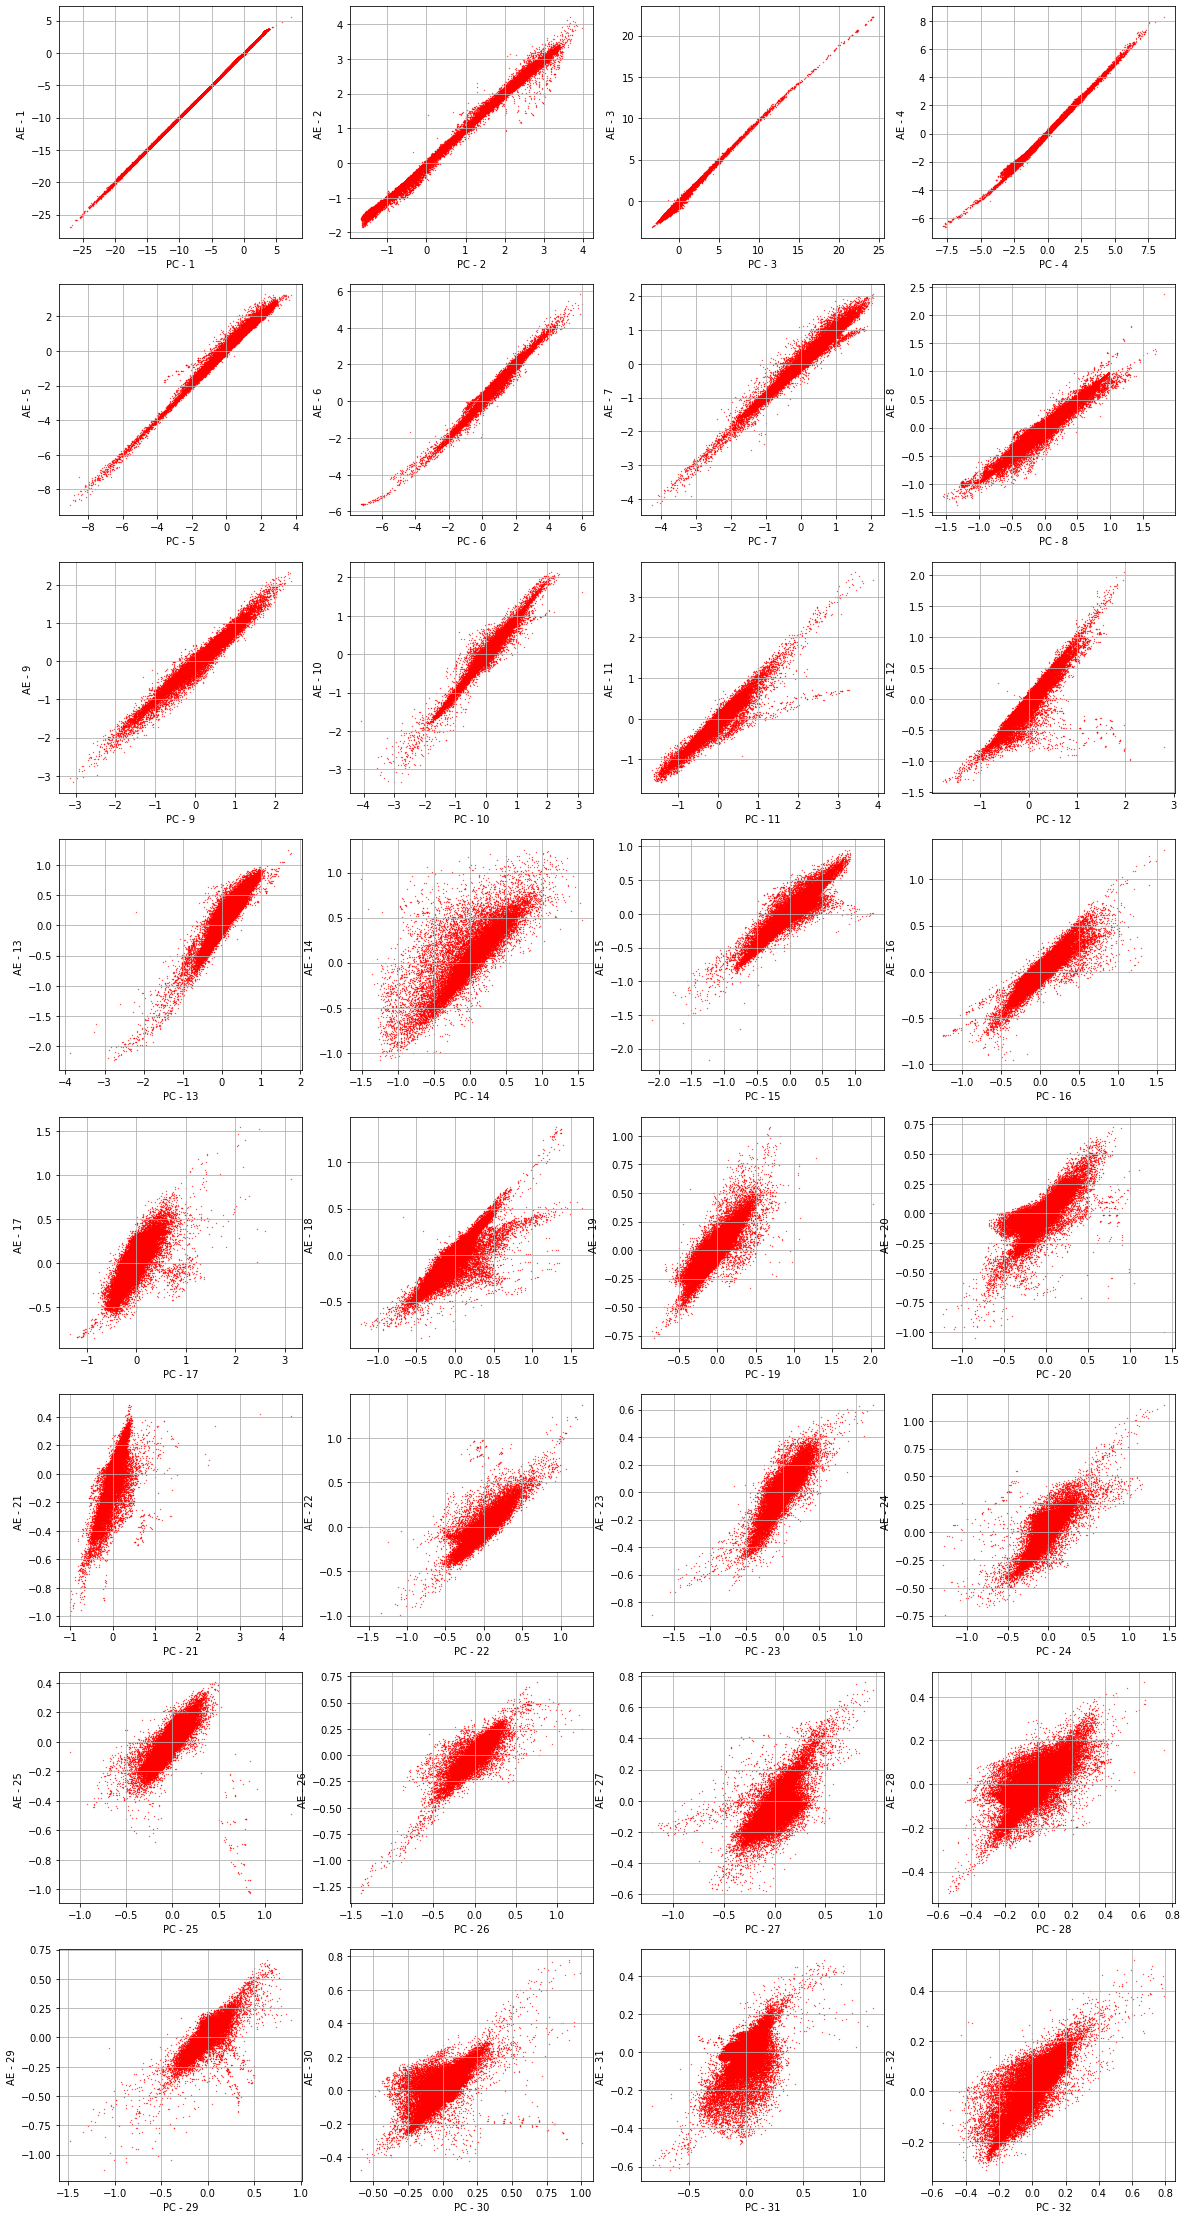

In [25]:
plot_err(tt.x_train, tt.ae_pred)

In [21]:
tt.eval(eigv)

In [93]:
def get_org(x, std, mean):
    return x * std + mean

In [ ]:
tt1 = tt.x_train*  std +f_mean

In [98]:
np.sum((flux  - ae_pred_org)**2, axis=1).mean()

3.866500359358726

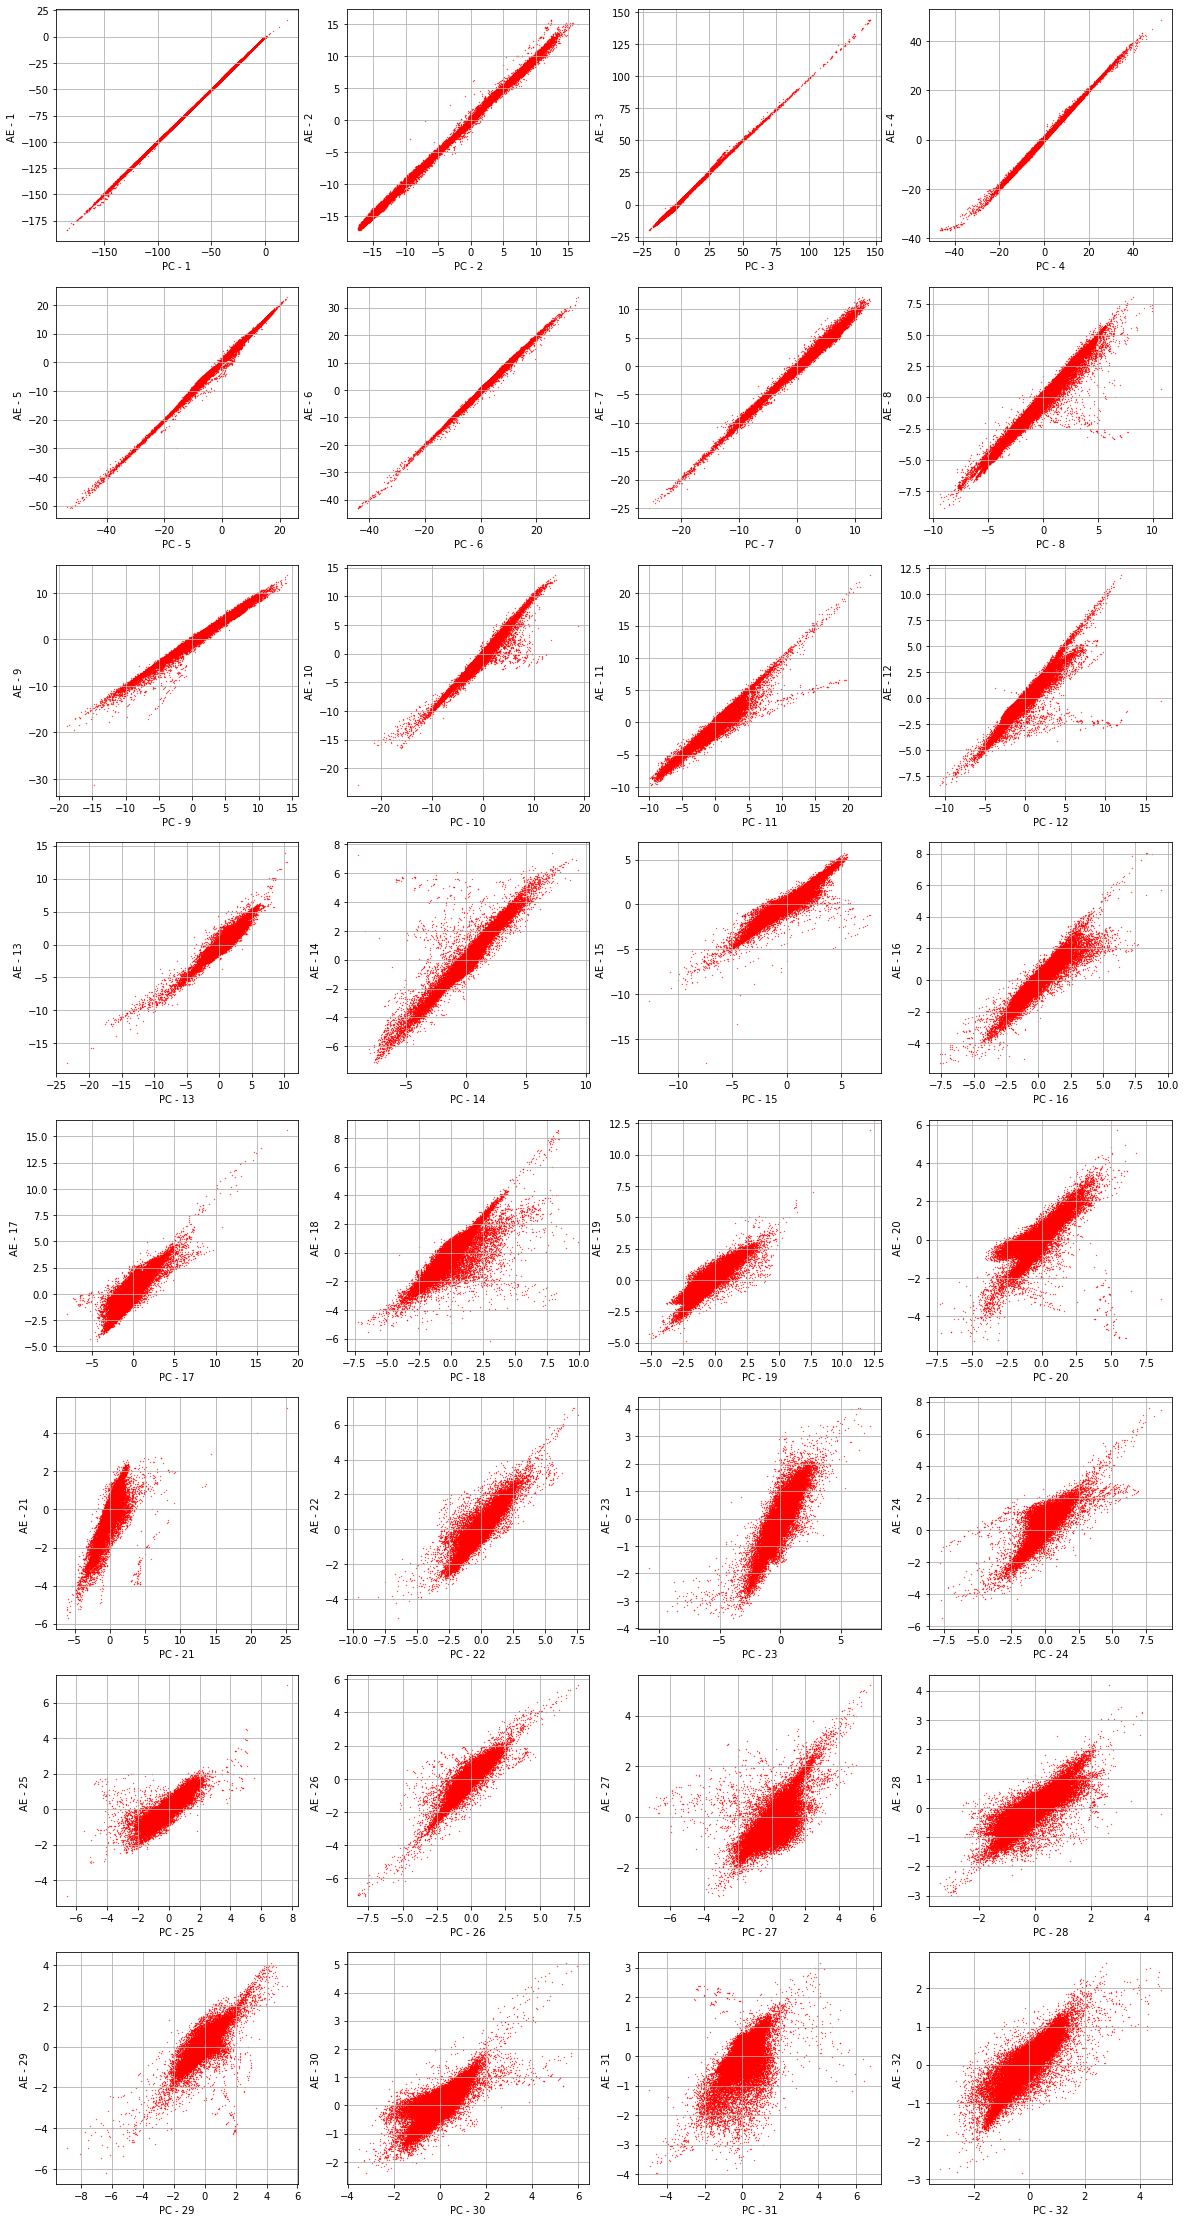

In [95]:
ae_pred_org = get_org(tt.ae_pred, std, f_mean)
plot_err(flux, ae_pred_org)

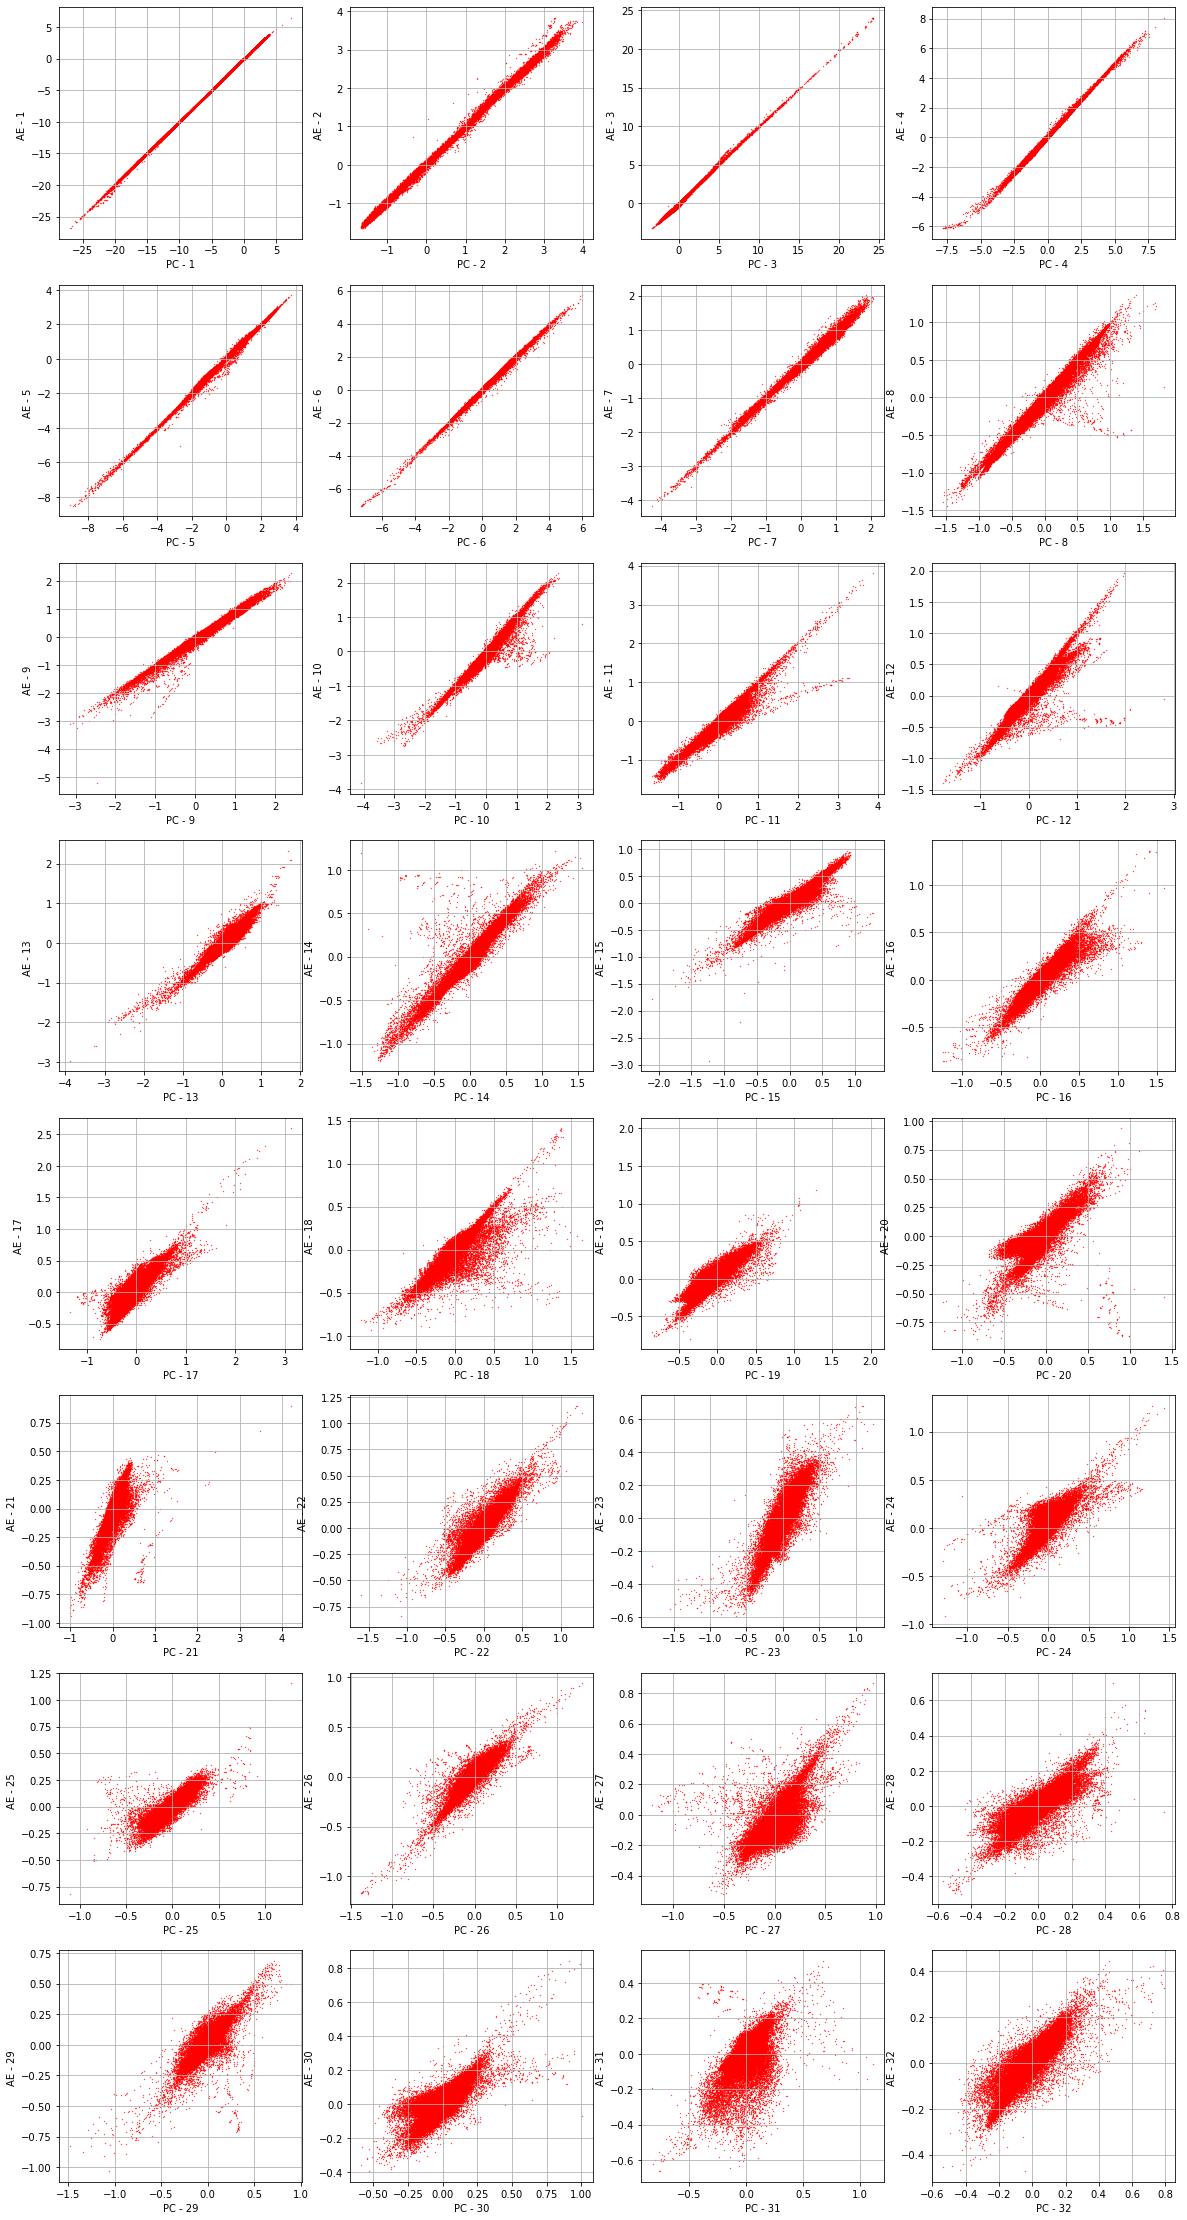

In [91]:
plot_err(tt.x_train, tt.ae_pred)

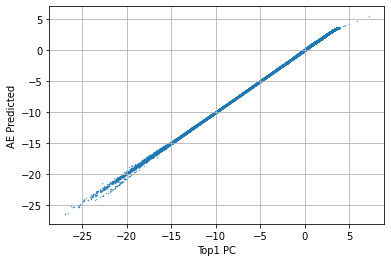

In [41]:
idx=0
plt.scatter(tt.x_train[:, idx],tt.ae_pred[:, idx], s=0.1)
# plt.plot(   s=0.1, c='k')
plt.xlabel(f"Top{idx+1} PC")
plt.ylabel("AE Predicted")

# plt.legend()
plt.grid(1)

In [24]:
def plot_err(org, rec):
    f, axs =  plt.subplots(8, 4,figsize=(20, 40))
    for idx, ax in enumerate(axs.flatten()):
        ax.scatter(org[:, idx],rec[:, idx], s=0.1, color  = 'r')
        ax.set_xlabel(f"PC - {idx + 1}")
        ax.set_ylabel(f"AE - {idx + 1} ")
        ax.grid(1)

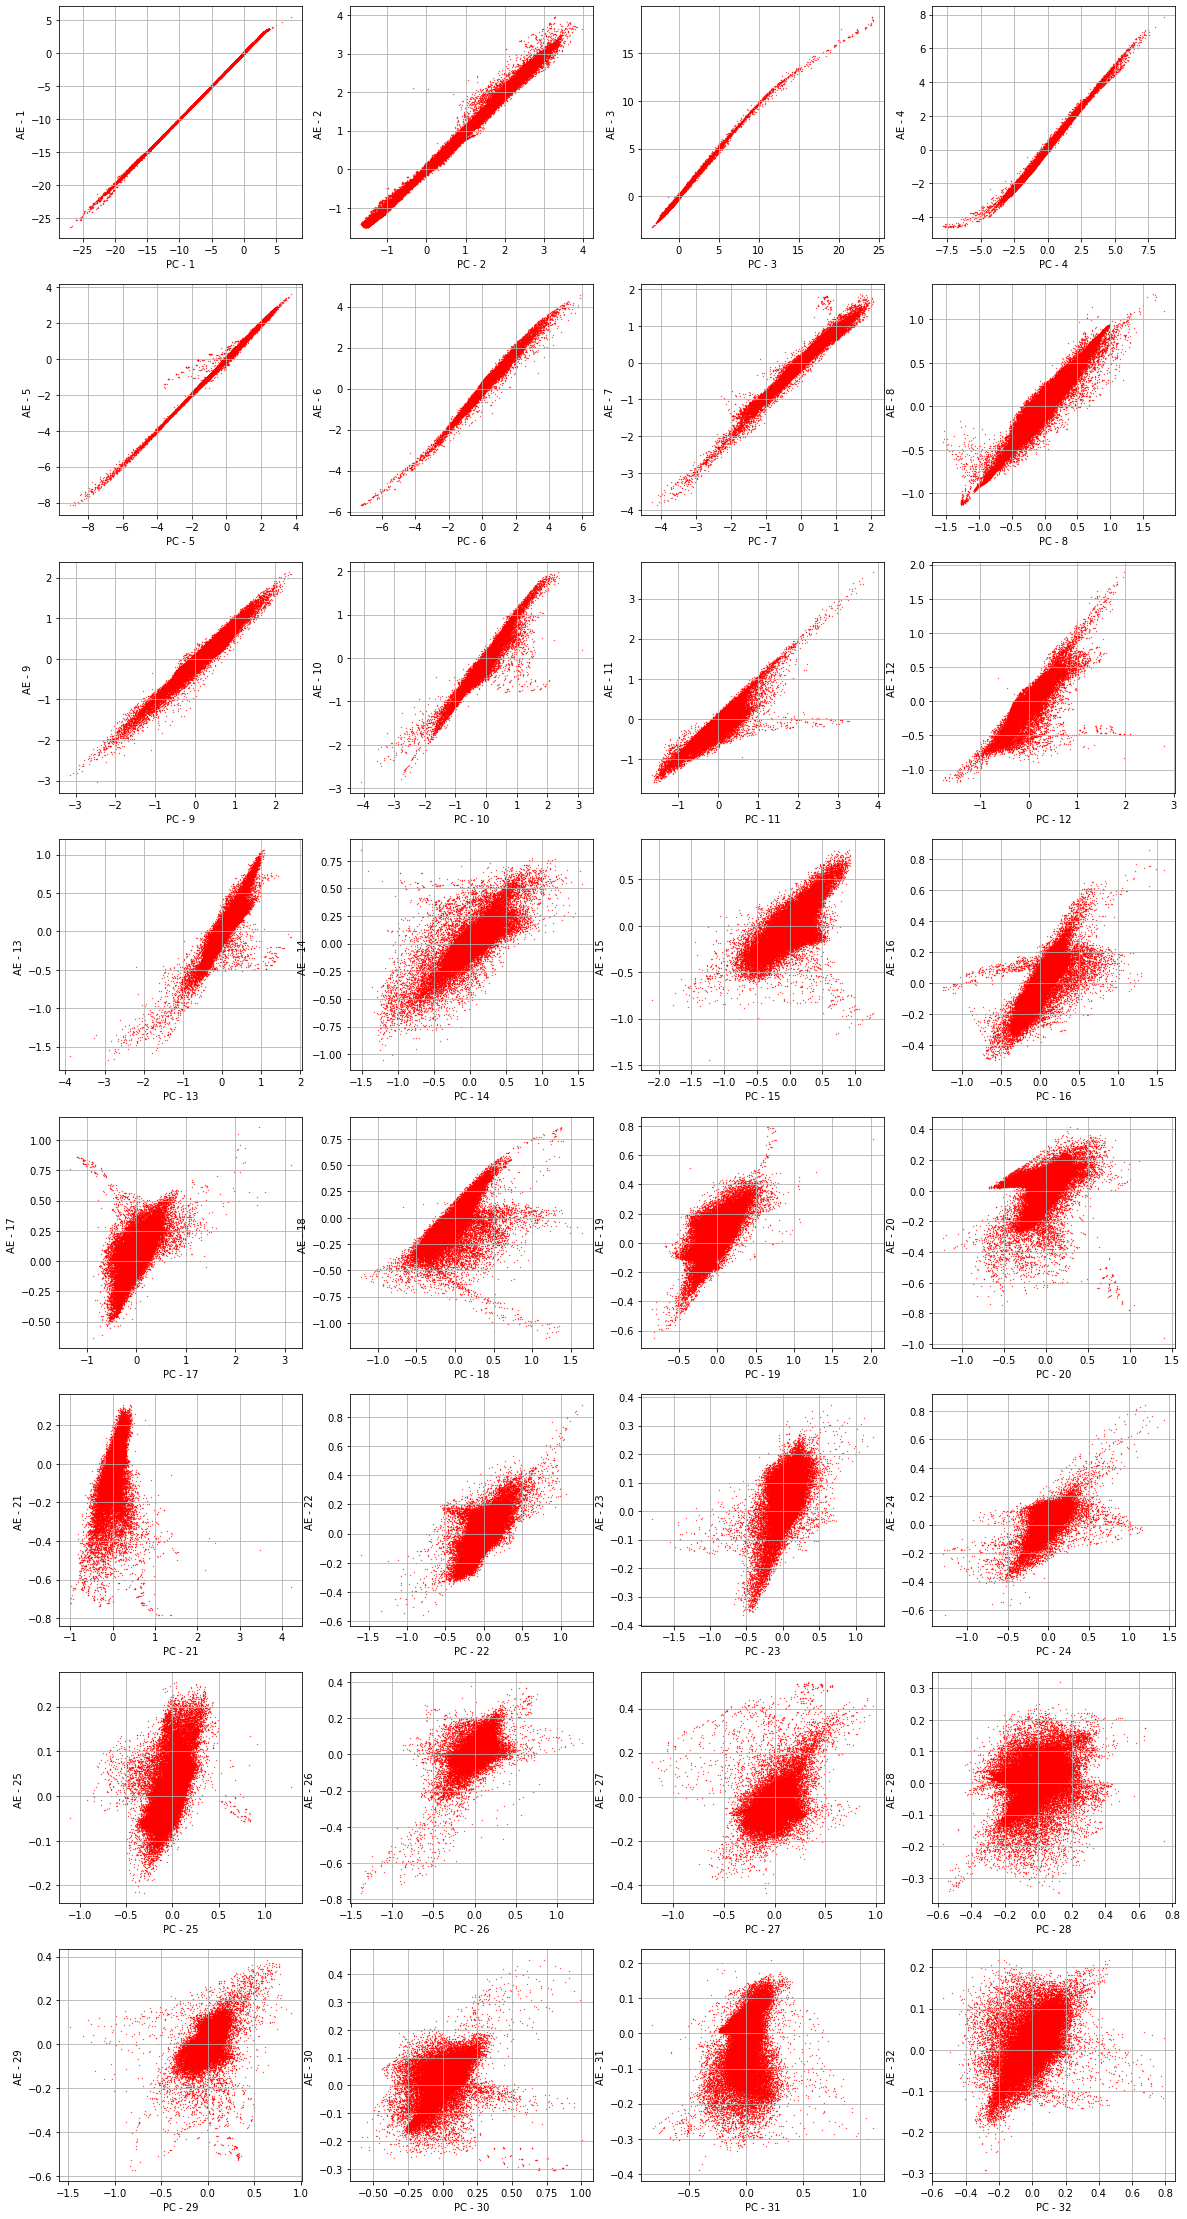

In [60]:
plot_err(tt.x_train, tt.ae_pred)

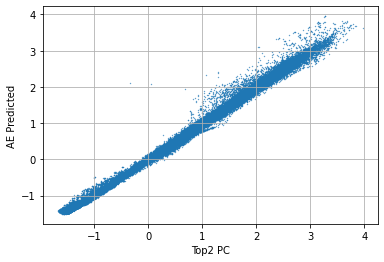

In [42]:
idx=1
plt.scatter(tt.x_train[:, idx],tt.ae_pred[:, idx], s=0.1)
# plt.plot(   s=0.1, c='k')
plt.xlabel(f"PC - {idx + 1}")
plt.ylabel(f"AE - {idx + 1} "`)

# plt.legend()
plt.grid(1)

In [99]:
en32 = mm.encoder.predict(data)

In [103]:
s =np.linalg.svd(en32, compute_uv=False)

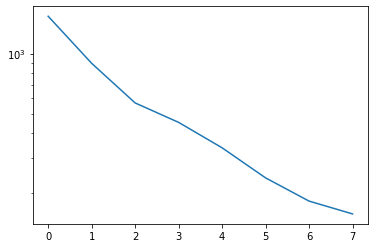

In [104]:
plt.plot( s )
# plt.xscale('log')
plt.yscale('log')

In [55]:
import warnings

In [56]:
warnings.filterwarnings("ignore")

In [26]:
import seaborn as sns

In [33]:
from ae.eval.plot_util import *

In [27]:
en32 = mm.encoder.predict(tt.x_train)

In [28]:
s =np.linalg.svd(en32, compute_uv=False)

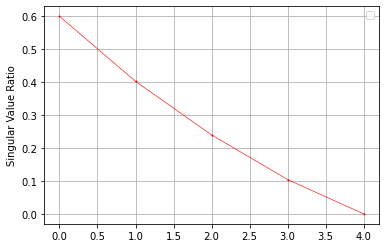

In [35]:
plot_s(s,xlog=0,ylog=0)

In [61]:
para0 = para[(para["OM"] == 1 ) & (para["CM"] == 3) ]

In [69]:
para_Fe = para0[(para["Te"] == 6)  & (para["Lg"] == 8) ]

In [71]:
enFe = en32[para_Fe.index,:]

In [74]:
dfFe = pd.DataFrame(data = enFe,columns=[f"pc{i}"  for i in range(1, mm.latent_dim + 1) ])

In [76]:
dfFe["Fe"]=Fe_H

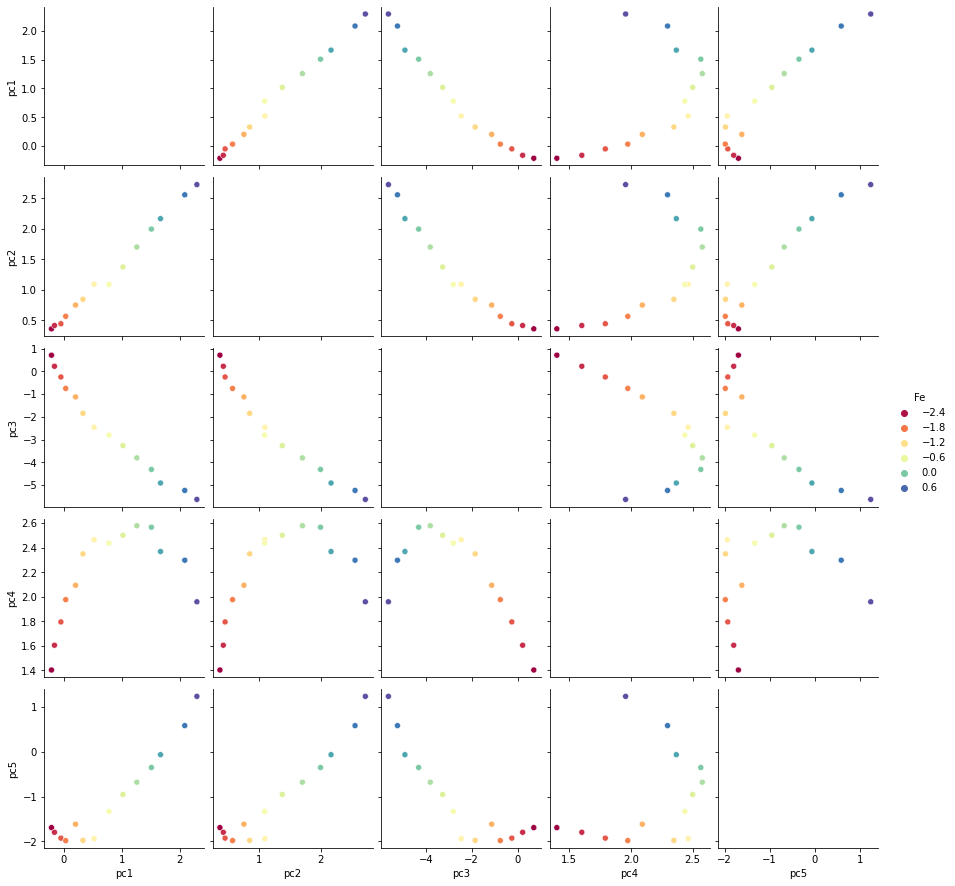

In [77]:
sns.pairplot(dfFe, hue="Fe", palette="Spectral")

In [79]:
import umap

In [82]:
en3200 = en32[para0.index,:]

In [83]:
en3200.shape

(6336, 5)

In [84]:
dfumap = umap.UMAP().fit_transform(en3200)

In [85]:
dfumap

array([[18.611647 ,  6.1904035],
       [18.86926  ,  6.3428383],
       [19.313515 ,  6.667004 ],
       ...,
       [-8.313057 ,  1.8353516],
       [-8.721141 ,  8.041097 ],
       [-5.2420487, 17.88234  ]], dtype=float32)

In [88]:
plt.style.use("ieee")

In [93]:
para0["u1"] = dfumap[:, 0]
para0["u2"] = dfumap[:, 1]

In [112]:
para0["p1"] = pcs[:, 0]
para0["p2"] = pcs[:, 1]

In [110]:
pcs = flux0[para0.index]

In [142]:
Fe_H

array([-2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25, -1.  , -0.75, -0.5 ,
       -0.25,  0.  ,  0.25,  0.5 ,  0.75])

In [ ]:
for para_name in 

In [145]:
para

Fe  Te  Lg  CM  OM         p1        p2
0        0   0   0   1   0 -30.338438  2.195663
1        0   0   0   1   1 -32.764657  2.281114
2        0   0   0   1   2 -35.870359  2.474615
3        0   0   0   1   3 -39.618324  2.673175
4        0   0   0   2   0 -31.107103  2.169074
...     ..  ..  ..  ..  ..        ...       ...
116609  13  60  10   4   3  -4.104047 -5.056857
116610  13  60  10   5   0  -3.438580 -4.956540
116611  13  60  10   5   1  -3.618532 -4.968871
116612  13  60  10   5   2  -3.835860 -4.973086
116613  13  60  10   5   3  -4.118878 -4.980532

[116614 rows x 7 columns]

In [146]:
log_g

array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ])

In [148]:
para["FeH"]=para["Fe"].map(lambda x: Fe_H[x])
para["Teff"]=para["Te"].map(lambda x: T_eff[x])
para["Logg"]=para["Lg"].map(lambda x: log_g[x])
para["C_M"]=para["CM"].map(lambda x: C_M[x])
para["O_M"]=para["OM"].map(lambda x: O_M[x])

In [156]:
para.to_csv("./para.csv")

In [199]:
para["p4"]=flux0[:,3]
para["p5"]=flux0[:,4]

In [208]:
para["p6"]=flux0[:,5]
para["p7"]=flux0[:,6]
para["p8"]=flux0[:,7]
para["p9"]=flux0[:,8]

In [ ]:
p


In [209]:
para0 = para[(para["OM"] == 1 ) & (para["CM"] == 3) ]

In [205]:
data

p1        p2        p3        p4        p5   FeH     Teff  \
9      -33.800363  2.131085 -5.416027  0.024973  3.202143 -2.50   3500.0   
29     -40.023893  2.926853 -5.883087  1.152064  4.643783 -2.50   3500.0   
49     -45.953753  3.805571 -7.035720  2.334191  6.348736 -2.50   3500.0   
69     -45.529586  4.299167 -8.048748  2.597064  7.182047 -2.50   3500.0   
85     -43.820162  4.573155 -8.223677  3.012159  7.592409 -2.50   3500.0   
...           ...       ...       ...       ...       ...   ...      ...   
116526   4.762276  0.634553 -1.736324  0.067981  0.589546  0.75  30000.0   
116543  -2.134988 -2.545087  0.626786  0.297334  0.012818  0.75  30000.0   
116563  -3.084944 -4.021800  0.970508  0.638176 -0.011964  0.75  30000.0   
116583  -3.481322 -4.756228  1.126319  0.792518 -0.066379  0.75  30000.0   
116603  -3.582939 -5.106168  1.245251  0.826136 -0.202051  0.75  30000.0   

        Logg  C_M  O_M  
9        0.0  0.0  0.0  
29       0.5  0.0  0.0  
49       1.0  0.0  0.0  
69       1.5  0.0  0.0  
85       2.0  0.0  0.0  
...      ...  ...  ...  
116526   3.0  0.0  0.0  
116543   3.5  0.0  0.0  
116563   4.0  0.0  0.0  
116583   4.5  0.0  0.0  
116603   5.0  0.0  0.0  

[6336 rows x 10 columns]

In [206]:
C_M

array([-0.75, -0.5 , -0.25,  0.  ,  0.25,  0.5 ])

In [207]:
O_M

array([-0.25,  0.  ,  0.25,  0.5 ])

In [155]:
para['p3'] = flux0[:, 2]

In [119]:
para['p1']=flux0[:, 0]
para['p2']=flux0[:, 1]

In [130]:
plt.style.use('default')

In [157]:
para0

Fe  Te  Lg  CM  OM         p1        p2   FeH     Teff  Logg  C_M  O_M
9        0   0   0   3   1 -33.800363  2.131085 -2.50   3500.0   0.0  0.0  0.0
29       0   0   1   3   1 -40.023893  2.926853 -2.50   3500.0   0.5  0.0  0.0
49       0   0   2   3   1 -45.953753  3.805571 -2.50   3500.0   1.0  0.0  0.0
69       0   0   3   3   1 -45.529586  4.299167 -2.50   3500.0   1.5  0.0  0.0
85       0   0   4   3   1 -43.820162  4.573155 -2.50   3500.0   2.0  0.0  0.0
...     ..  ..  ..  ..  ..        ...       ...   ...      ...   ...  ...  ...
116526  13  60   6   3   1   4.762276  0.634553  0.75  30000.0   3.0  0.0  0.0
116543  13  60   7   3   1  -2.134988 -2.545087  0.75  30000.0   3.5  0.0  0.0
116563  13  60   8   3   1  -3.084944 -4.021800  0.75  30000.0   4.0  0.0  0.0
116583  13  60   9   3   1  -3.481322 -4.756228  0.75  30000.0   4.5  0.0  0.0
116603  13  60  10   3   1  -3.582939 -5.106168  0.75  30000.0   5.0  0.0  0.0

[6336 rows x 12 columns]

In [ ]:
def get_heatmap

In [161]:
df = para0

In [162]:
df0 = df[df["Lg"]==0]

In [163]:
df0.shape

(154, 12)

In [167]:
df_pivot = df0.pivot(index="FeH", columns="Teff", values="p1")

In [ ]:
g = sns.FacetGrid(tips, row="smoker", col="time", margin_titles=True)
g.map(sns.heatmap, "size", "total_bill", color=".3", fit_reg=False, x_jitter=.1)

In [171]:
para.columns

Index(['Fe', 'Te', 'Lg', 'CM', 'OM', 'p1', 'p2', 'FeH', 'Teff', 'Logg', 'C_M',
       'O_M', 'p3'],
      dtype='object')

In [210]:
data=para0[['p1', 'p2','p3','p4','p5','p6','p7','p8','p9', 'FeH', 'Teff', 'Logg', 'C_M',
       'O_M']]

In [211]:
data

p1        p2        p3        p4        p5        p6        p7  \
9      -33.800363  2.131085 -5.416027  0.024973  3.202143 -3.241726 -2.007096   
29     -40.023893  2.926853 -5.883087  1.152064  4.643783 -3.341978 -3.010518   
49     -45.953753  3.805571 -7.035720  2.334191  6.348736 -4.518051 -3.696293   
69     -45.529586  4.299167 -8.048748  2.597064  7.182047 -6.337295 -3.595001   
85     -43.820162  4.573155 -8.223677  3.012159  7.592409 -7.638853 -3.831861   
...           ...       ...       ...       ...       ...       ...       ...   
116526   4.762276  0.634553 -1.736324  0.067981  0.589546 -0.099170 -0.047920   
116543  -2.134988 -2.545087  0.626786  0.297334  0.012818 -0.325747  0.215998   
116563  -3.084944 -4.021800  0.970508  0.638176 -0.011964 -0.316482  0.154302   
116583  -3.481322 -4.756228  1.126319  0.792518 -0.066379 -0.287180  0.070675   
116603  -3.582939 -5.106168  1.245251  0.826136 -0.202051 -0.235095 -0.083171   

              p8        p9   FeH     Teff  Logg  C_M  O_M  
9       0.351996 -3.373070 -2.50   3500.0   0.0  0.0  0.0  
29      0.389576 -3.090039 -2.50   3500.0   0.5  0.0  0.0  
49      0.516732 -3.839569 -2.50   3500.0   1.0  0.0  0.0  
69      0.603336 -4.585351 -2.50   3500.0   1.5  0.0  0.0  
85      0.639438 -5.008319 -2.50   3500.0   2.0  0.0  0.0  
...          ...       ...   ...      ...   ...  ...  ...  
116526  0.133084 -0.540102  0.75  30000.0   3.0  0.0  0.0  
116543 -0.563979  0.129087  0.75  30000.0   3.5  0.0  0.0  
116563  0.008245  0.272909  0.75  30000.0   4.0  0.0  0.0  
116583  0.675152  0.443028  0.75  30000.0   4.5  0.0  0.0  
116603  1.337118  0.607724  0.75  30000.0   5.0  0.0  0.0  

[6336 rows x 14 columns]

In [194]:
def draw_heatmap(*args, **kwargs):
    data = kwargs.pop('data')
    d = data.pivot(index=args[1], columns=args[0], values=args[2])
    sns.heatmap(d, **kwargs)
def plot_PC_in_paras(data, pc="p1", save=0):
    fg = sns.FacetGrid(data, col='Logg', col_wrap=4, height=5, aspect=1)
    fg.map_dataframe(draw_heatmap, 'FeH', 'Teff', pc, cmap="Spectral", cbar=True, square = False)
    if save: plt.savefig(f"{pc}.png")

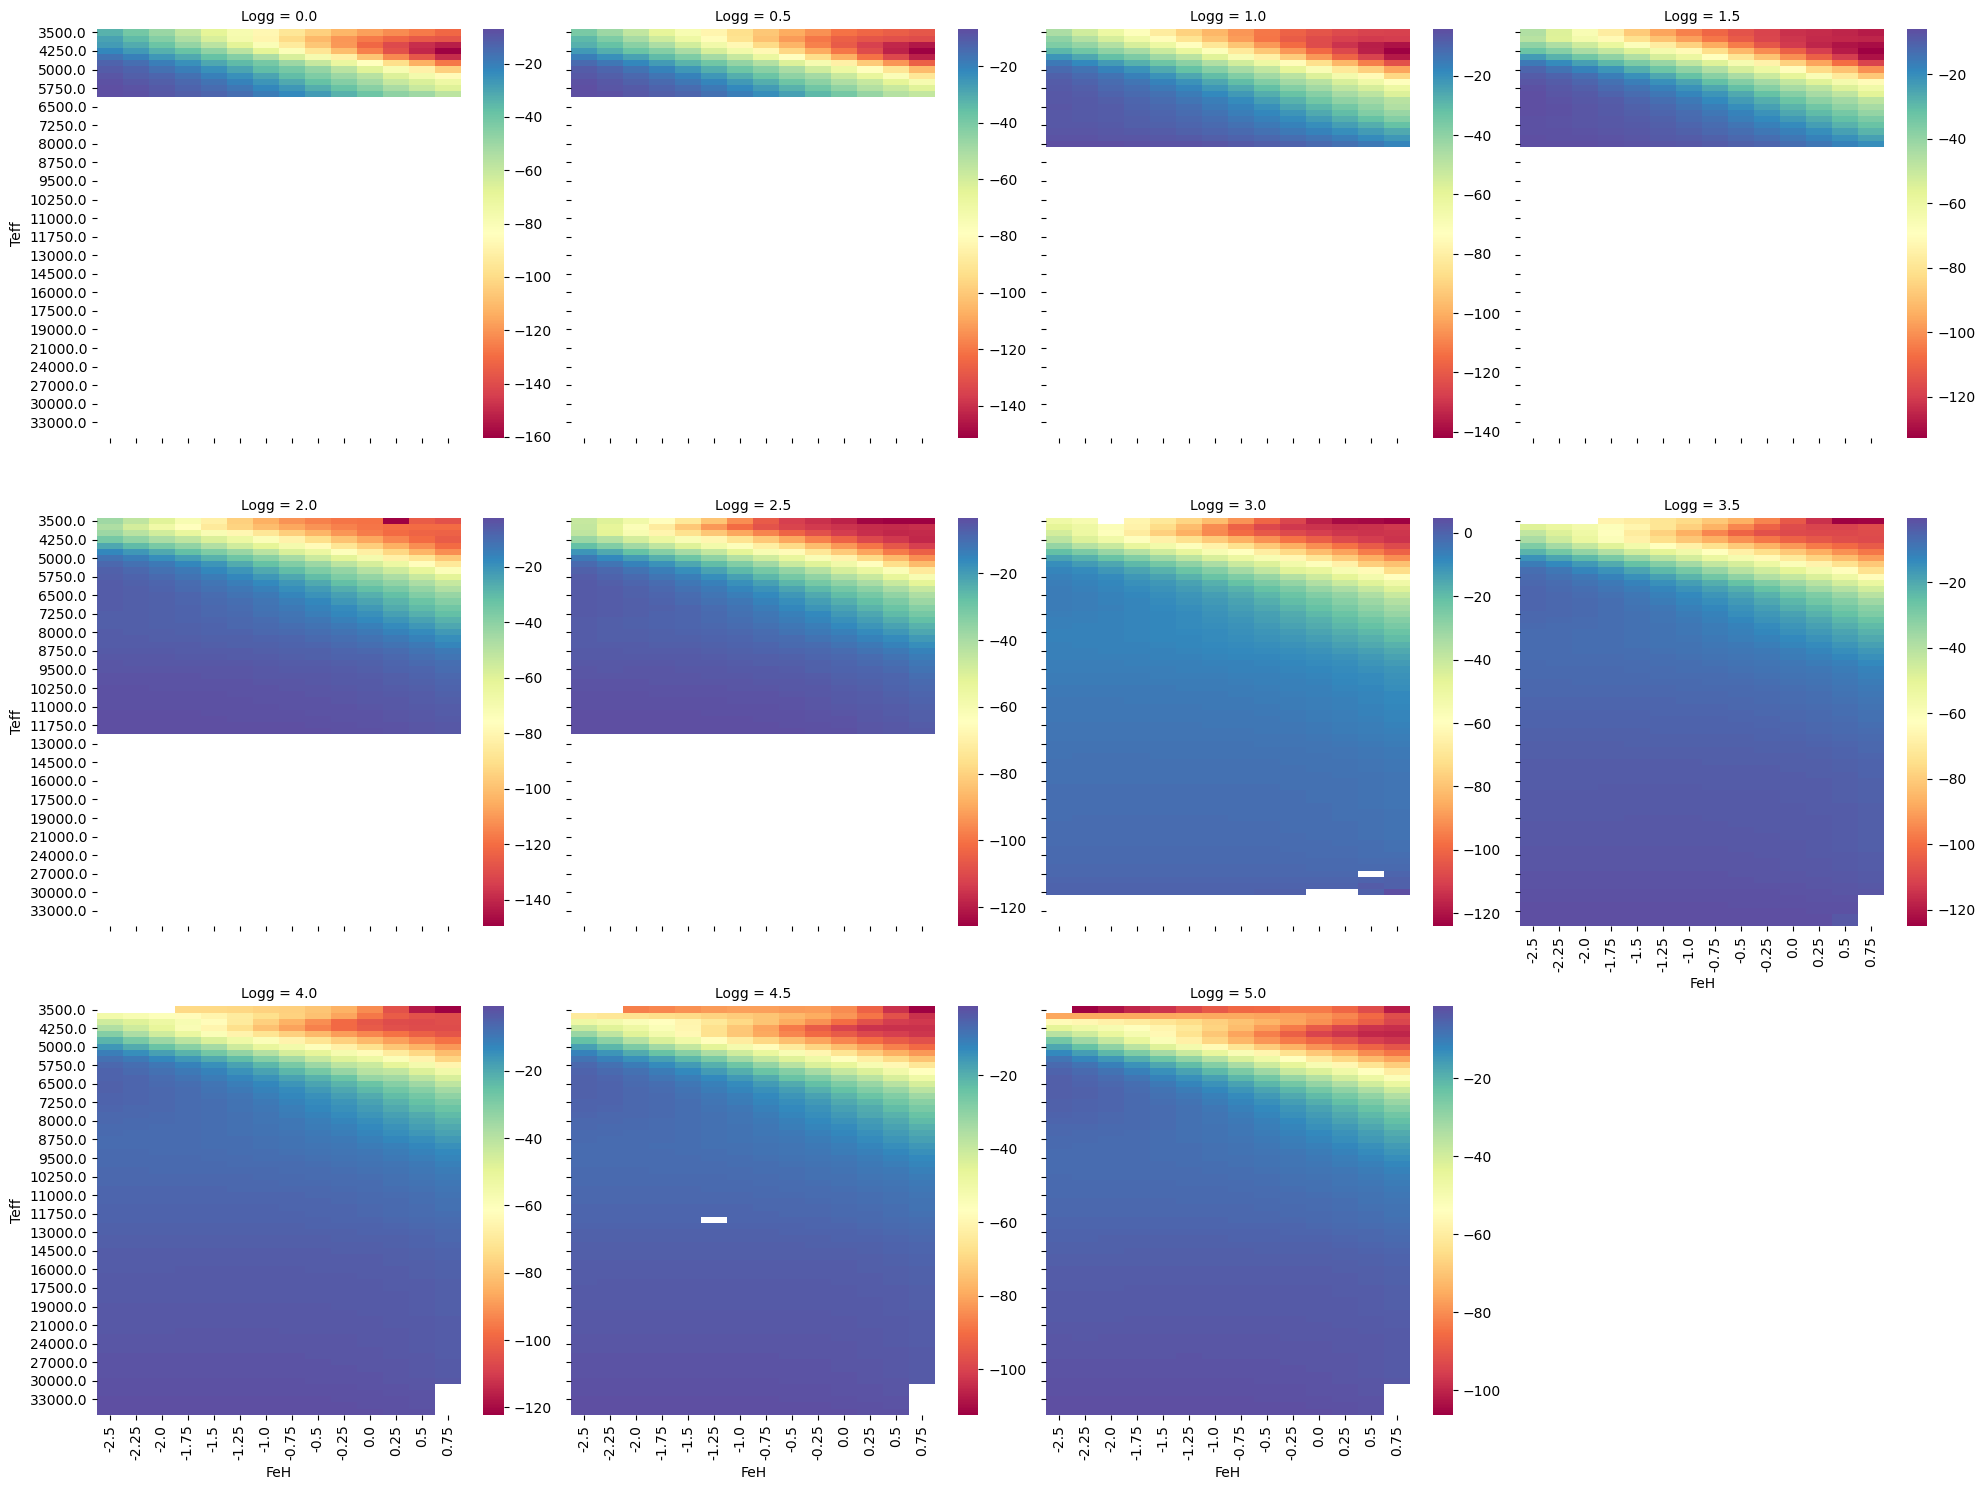

In [214]:
plot_PC_in_paras(data, pc="p1", save=0)



In [ ]:
8415, 8700

In [216]:
idx1 = np.digitize(8415, wave)
idx1

10314

In [217]:
idx2 = np.digitize(8700, wave)
idx2

10647

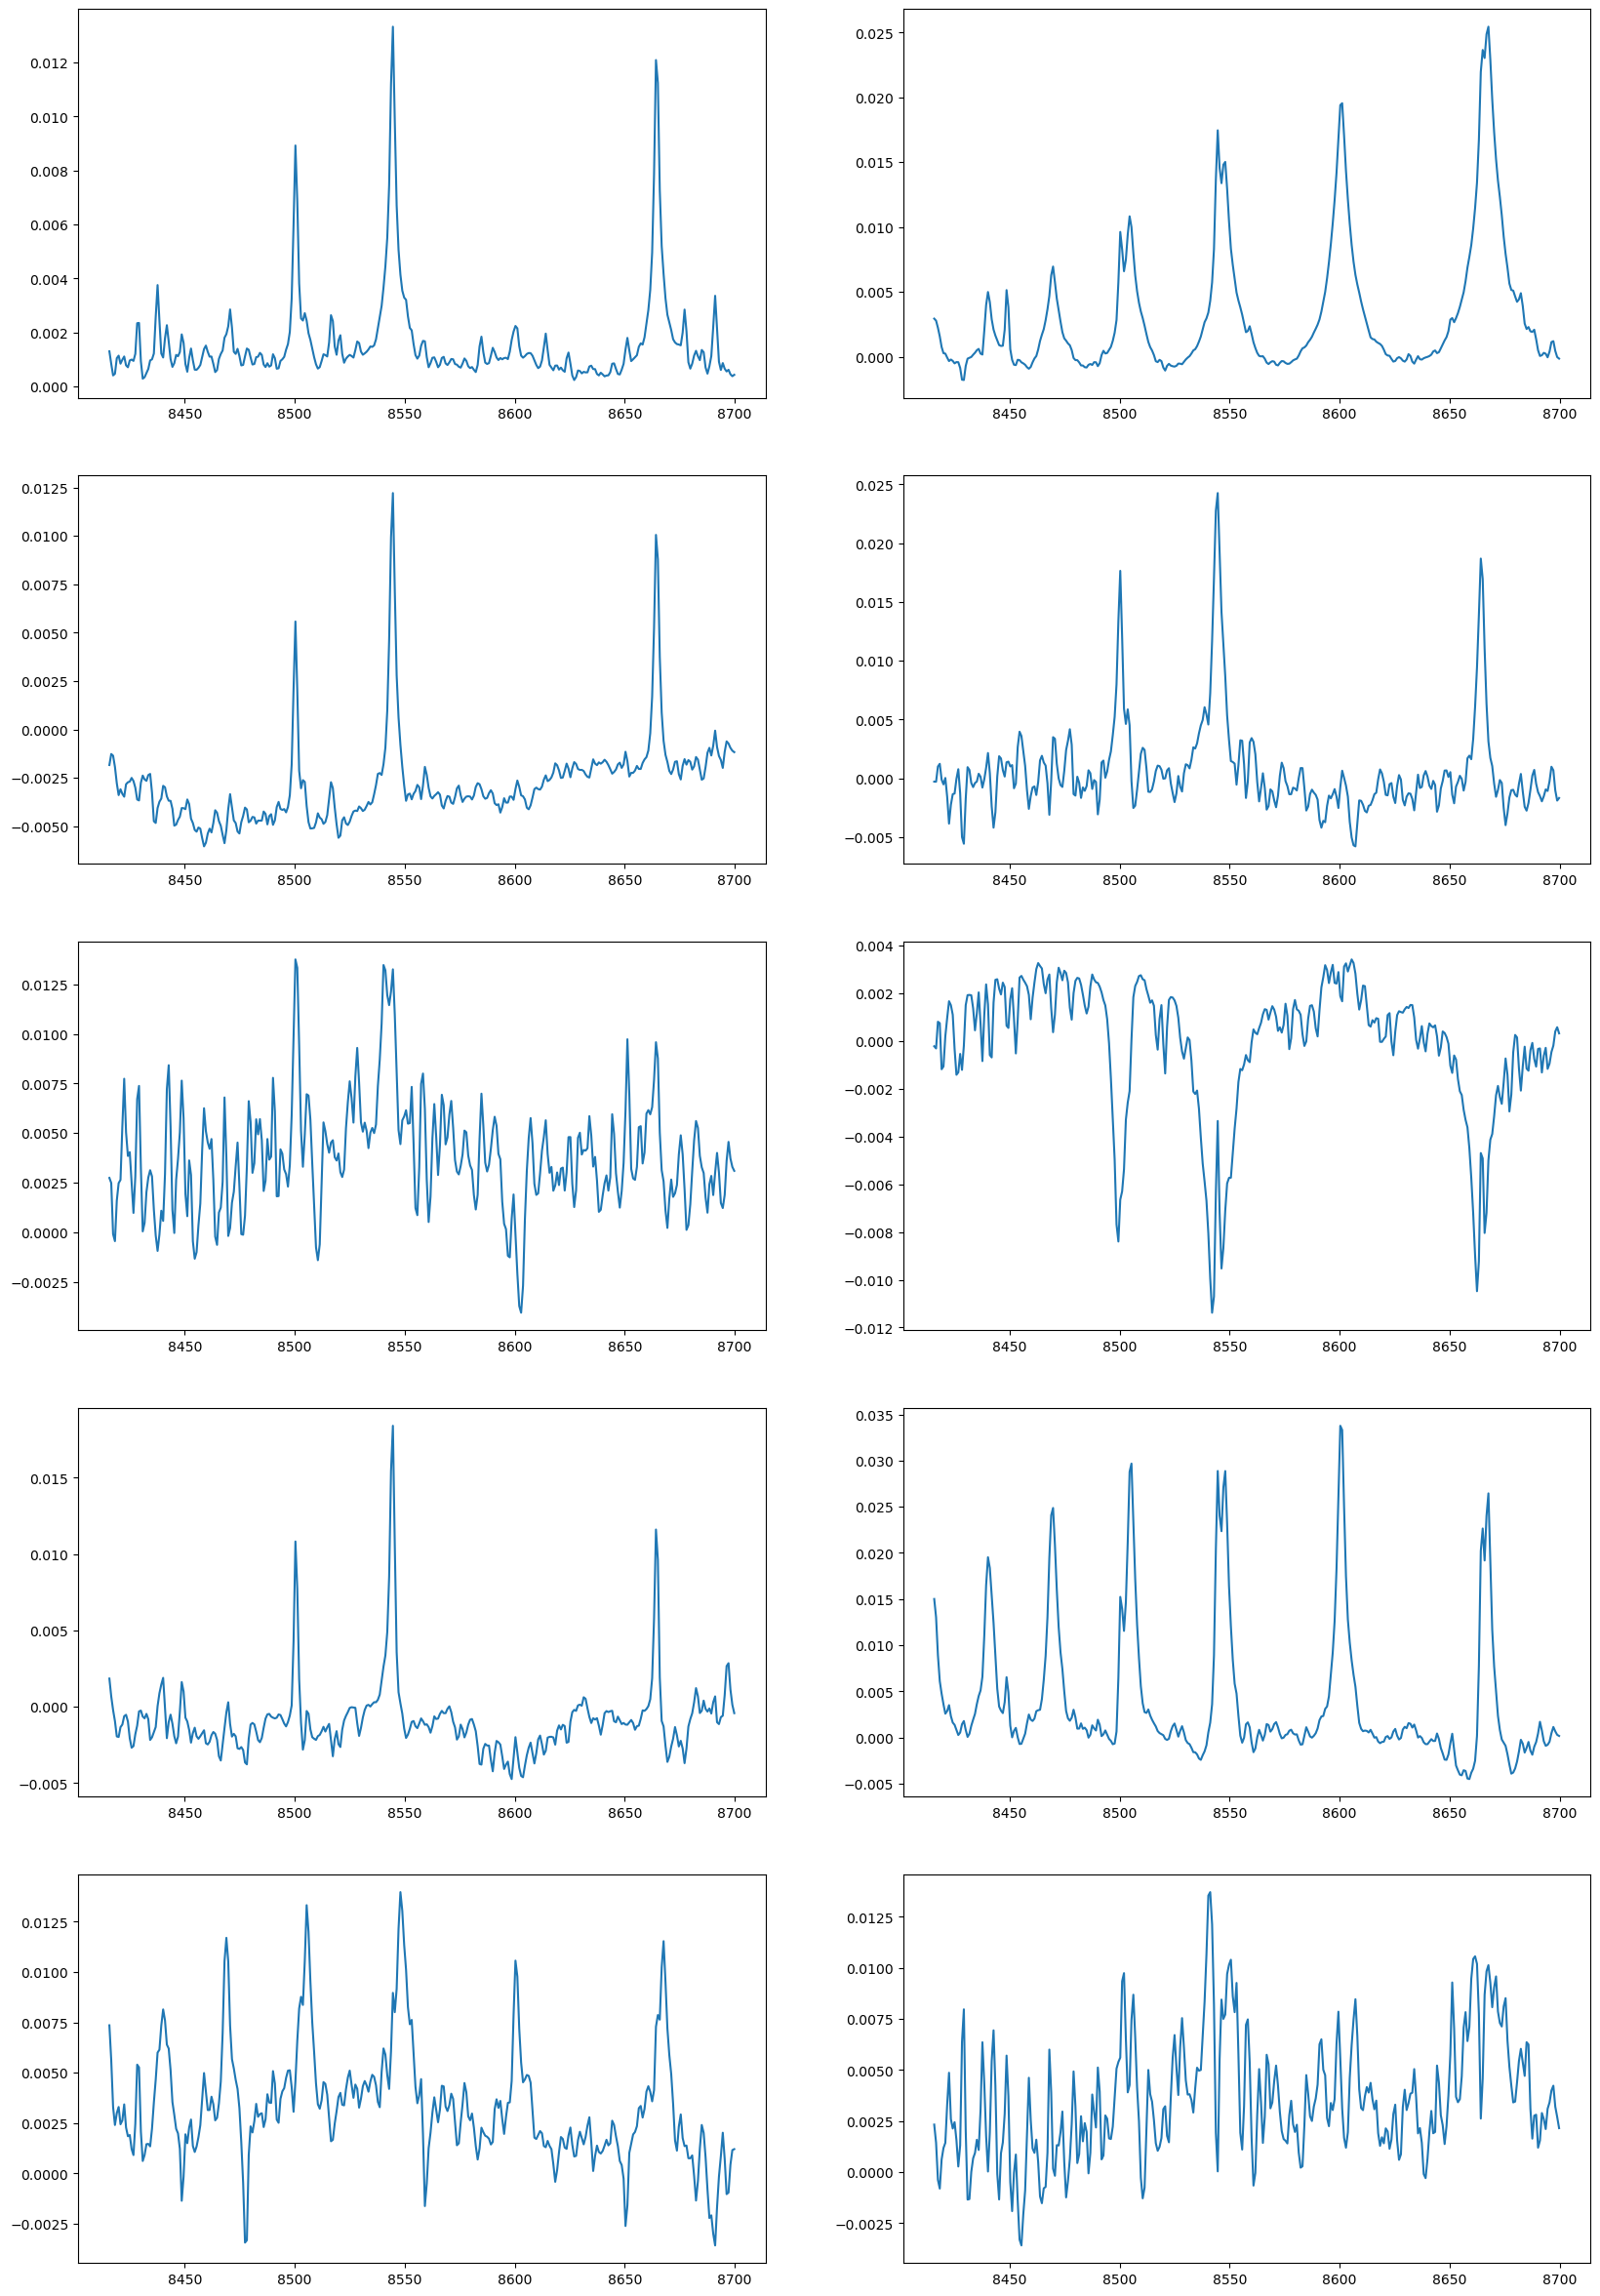

In [232]:

f, axs = plt.subplots(5,2, figsize=(20,30))
for ii , ax in enumerate(axs.flatten()):
    ax.plot(wave[idx1:idx2],eigv[idx1:idx2,ii])    

In [ ]:
u,s,v = np.linalg.svd(flux0[idx1:idx2, :])

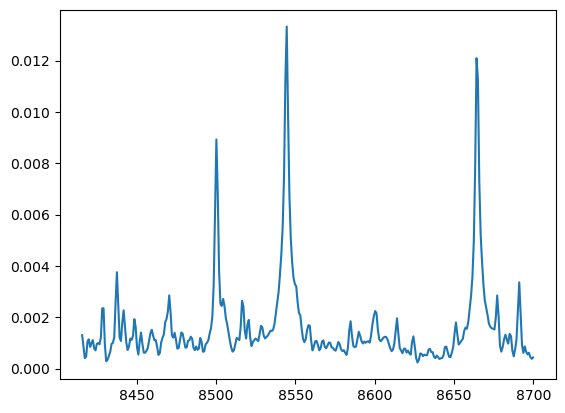

In [219]:
plt.plot(wave[idx1:idx2],eigv[idx1:idx2, 0])

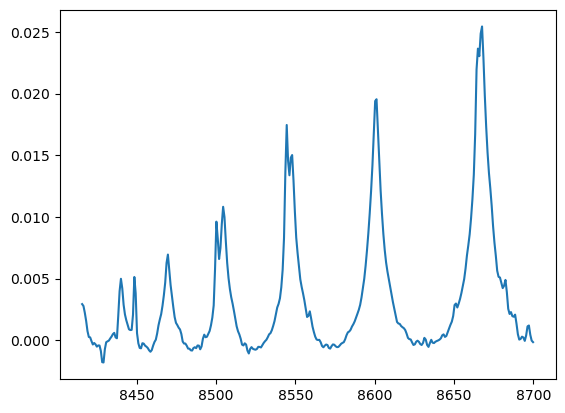

In [220]:
plt.plot(wave[idx1:idx2],eigv[idx1:idx2, 1])b


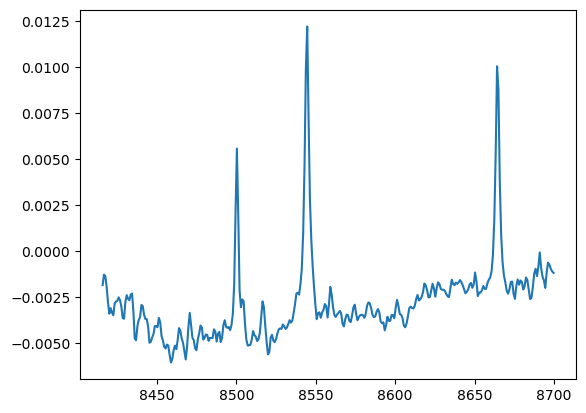

In [221]:
plt.plot(wave[idx1:idx2],eigv[idx1:idx2, 2])



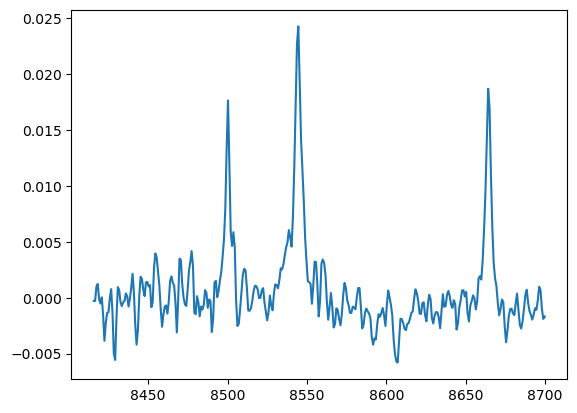

In [223]:
plt.plot(wave[idx1:idx2],eigv[idx1:idx2, 3])



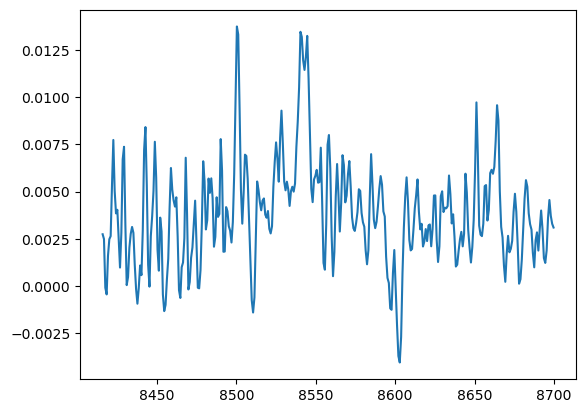

In [222]:
plt.plot(wave[idx1:idx2],eigv[idx1:idx2, 4])



In [ ]:
plt.plot(flux0[0]

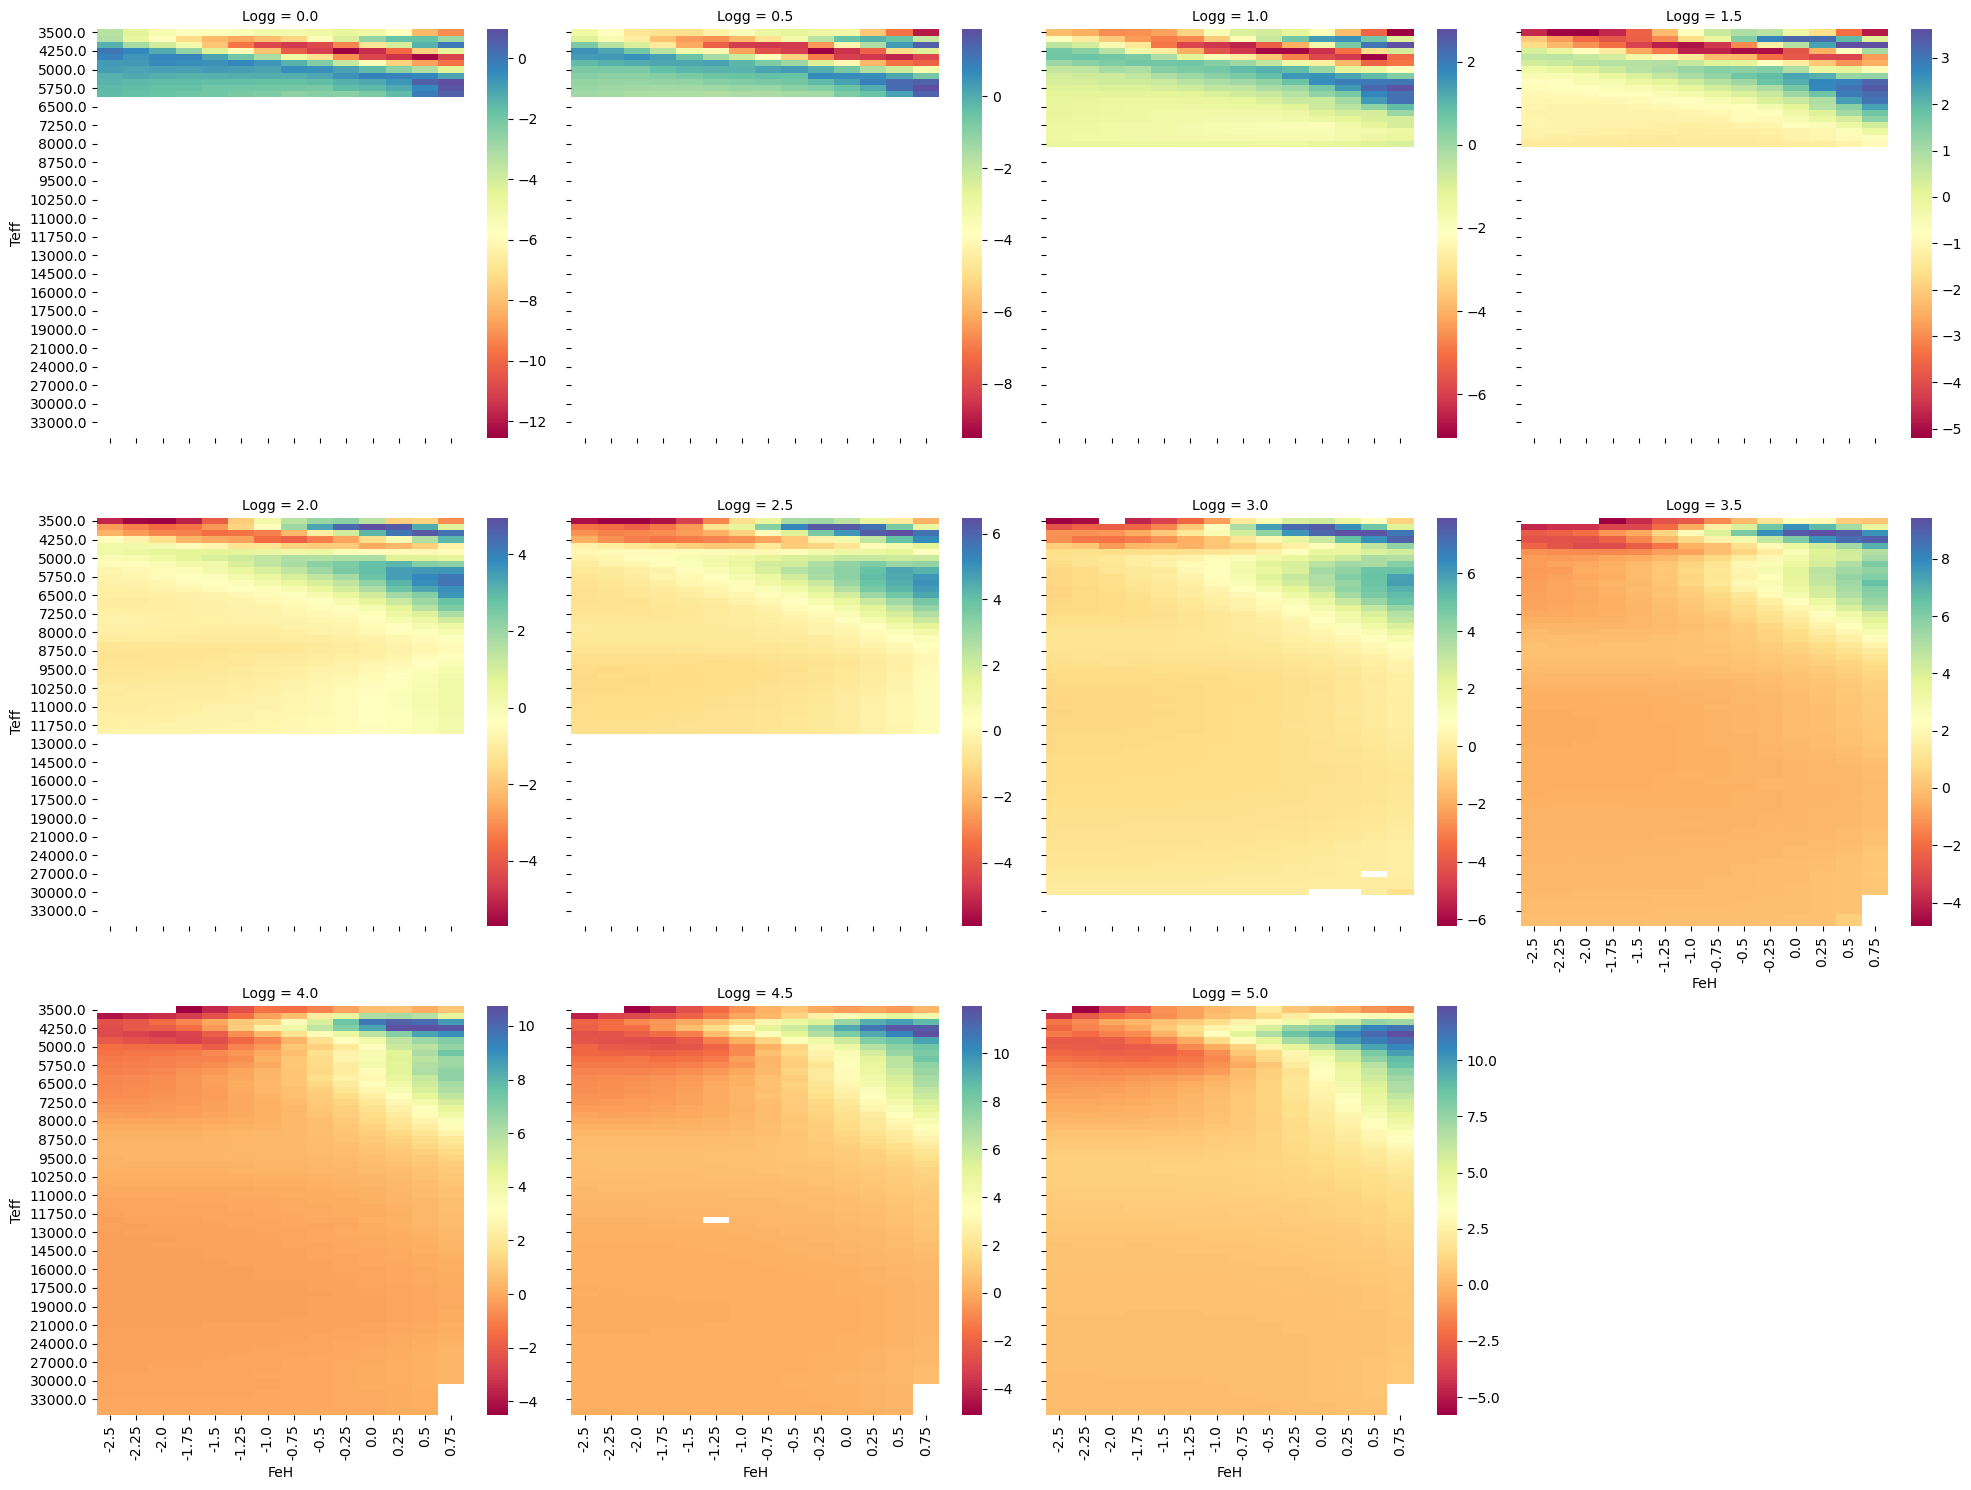

In [212]:
plot_PC_in_paras(data, pc="p9", save=0)


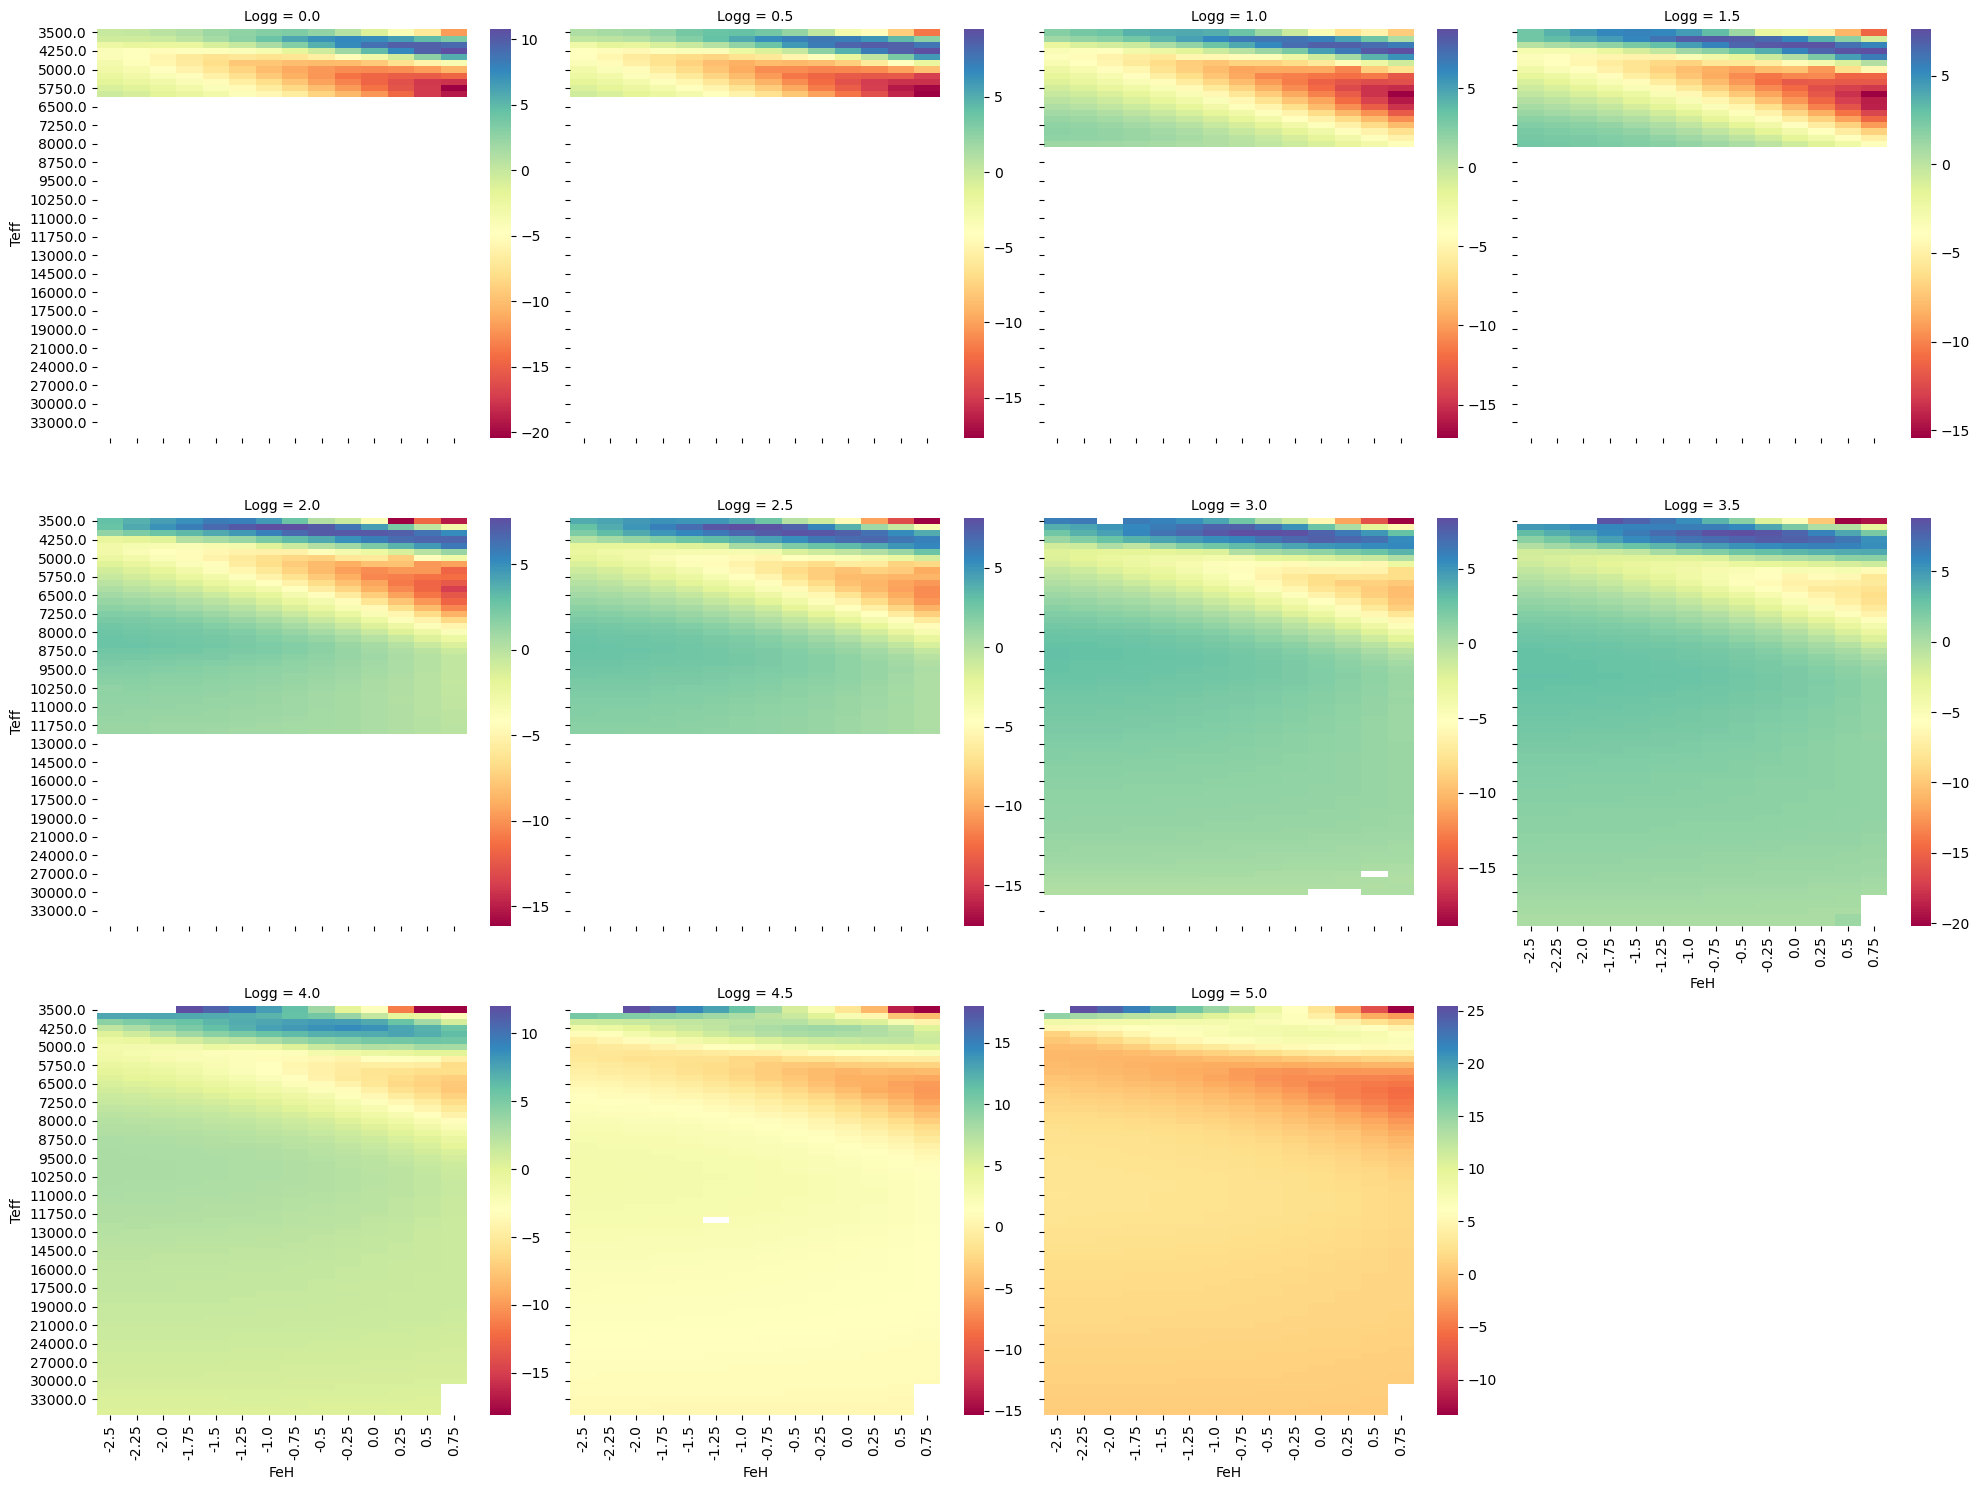

In [203]:

plot_PC_in_paras(data, pc="p4", save=0)

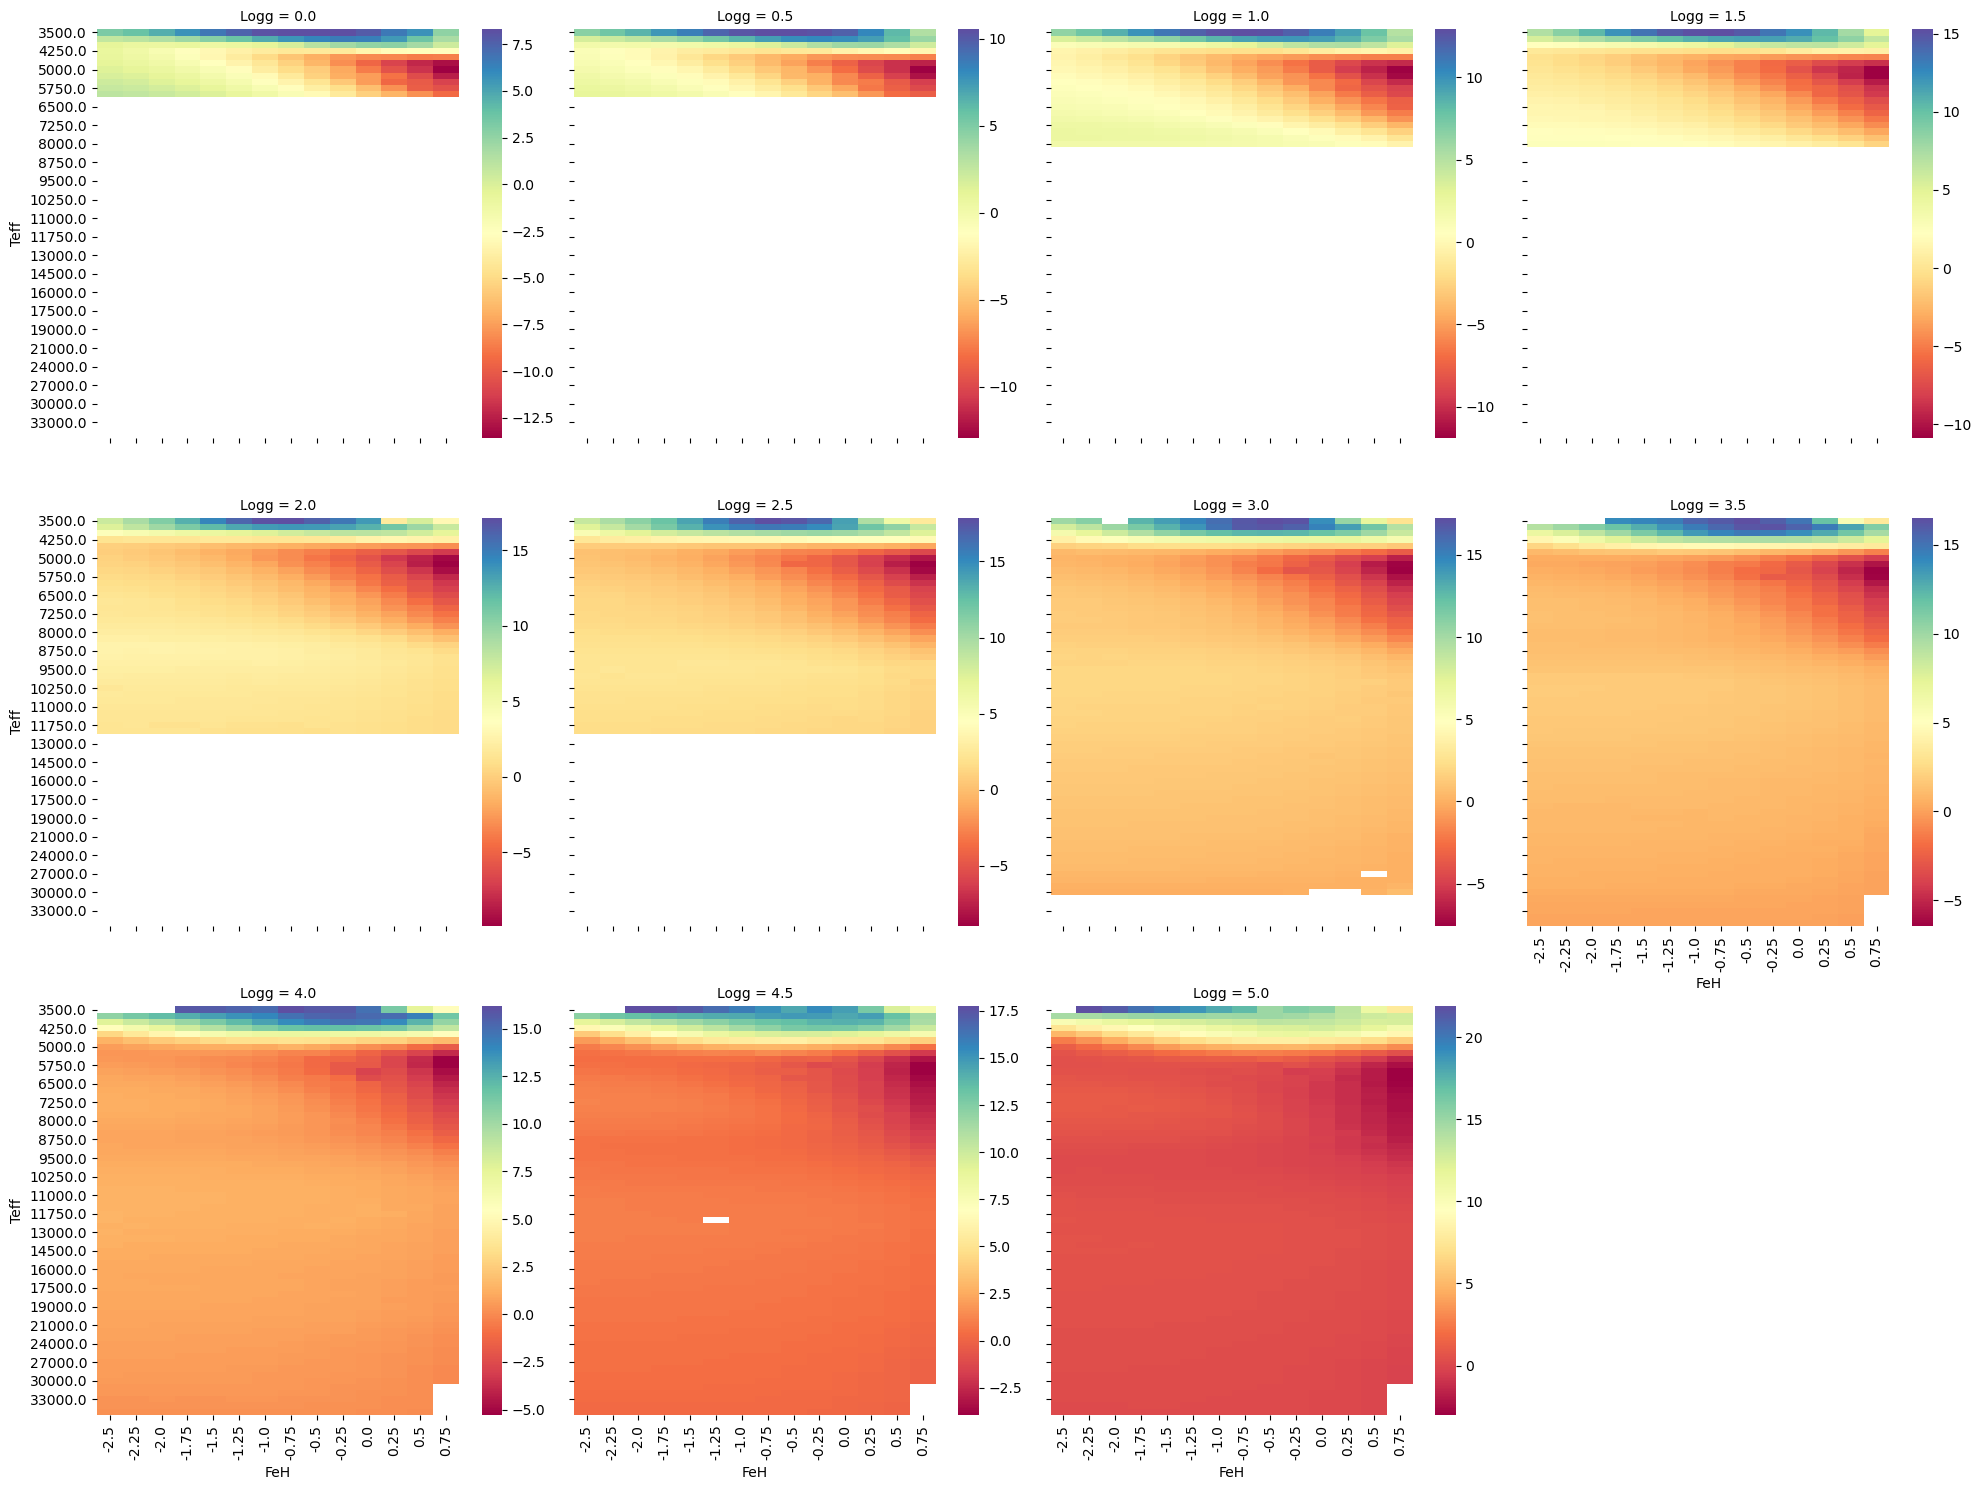

In [204]:
plot_PC_in_paras(data, pc="p5", save=1)

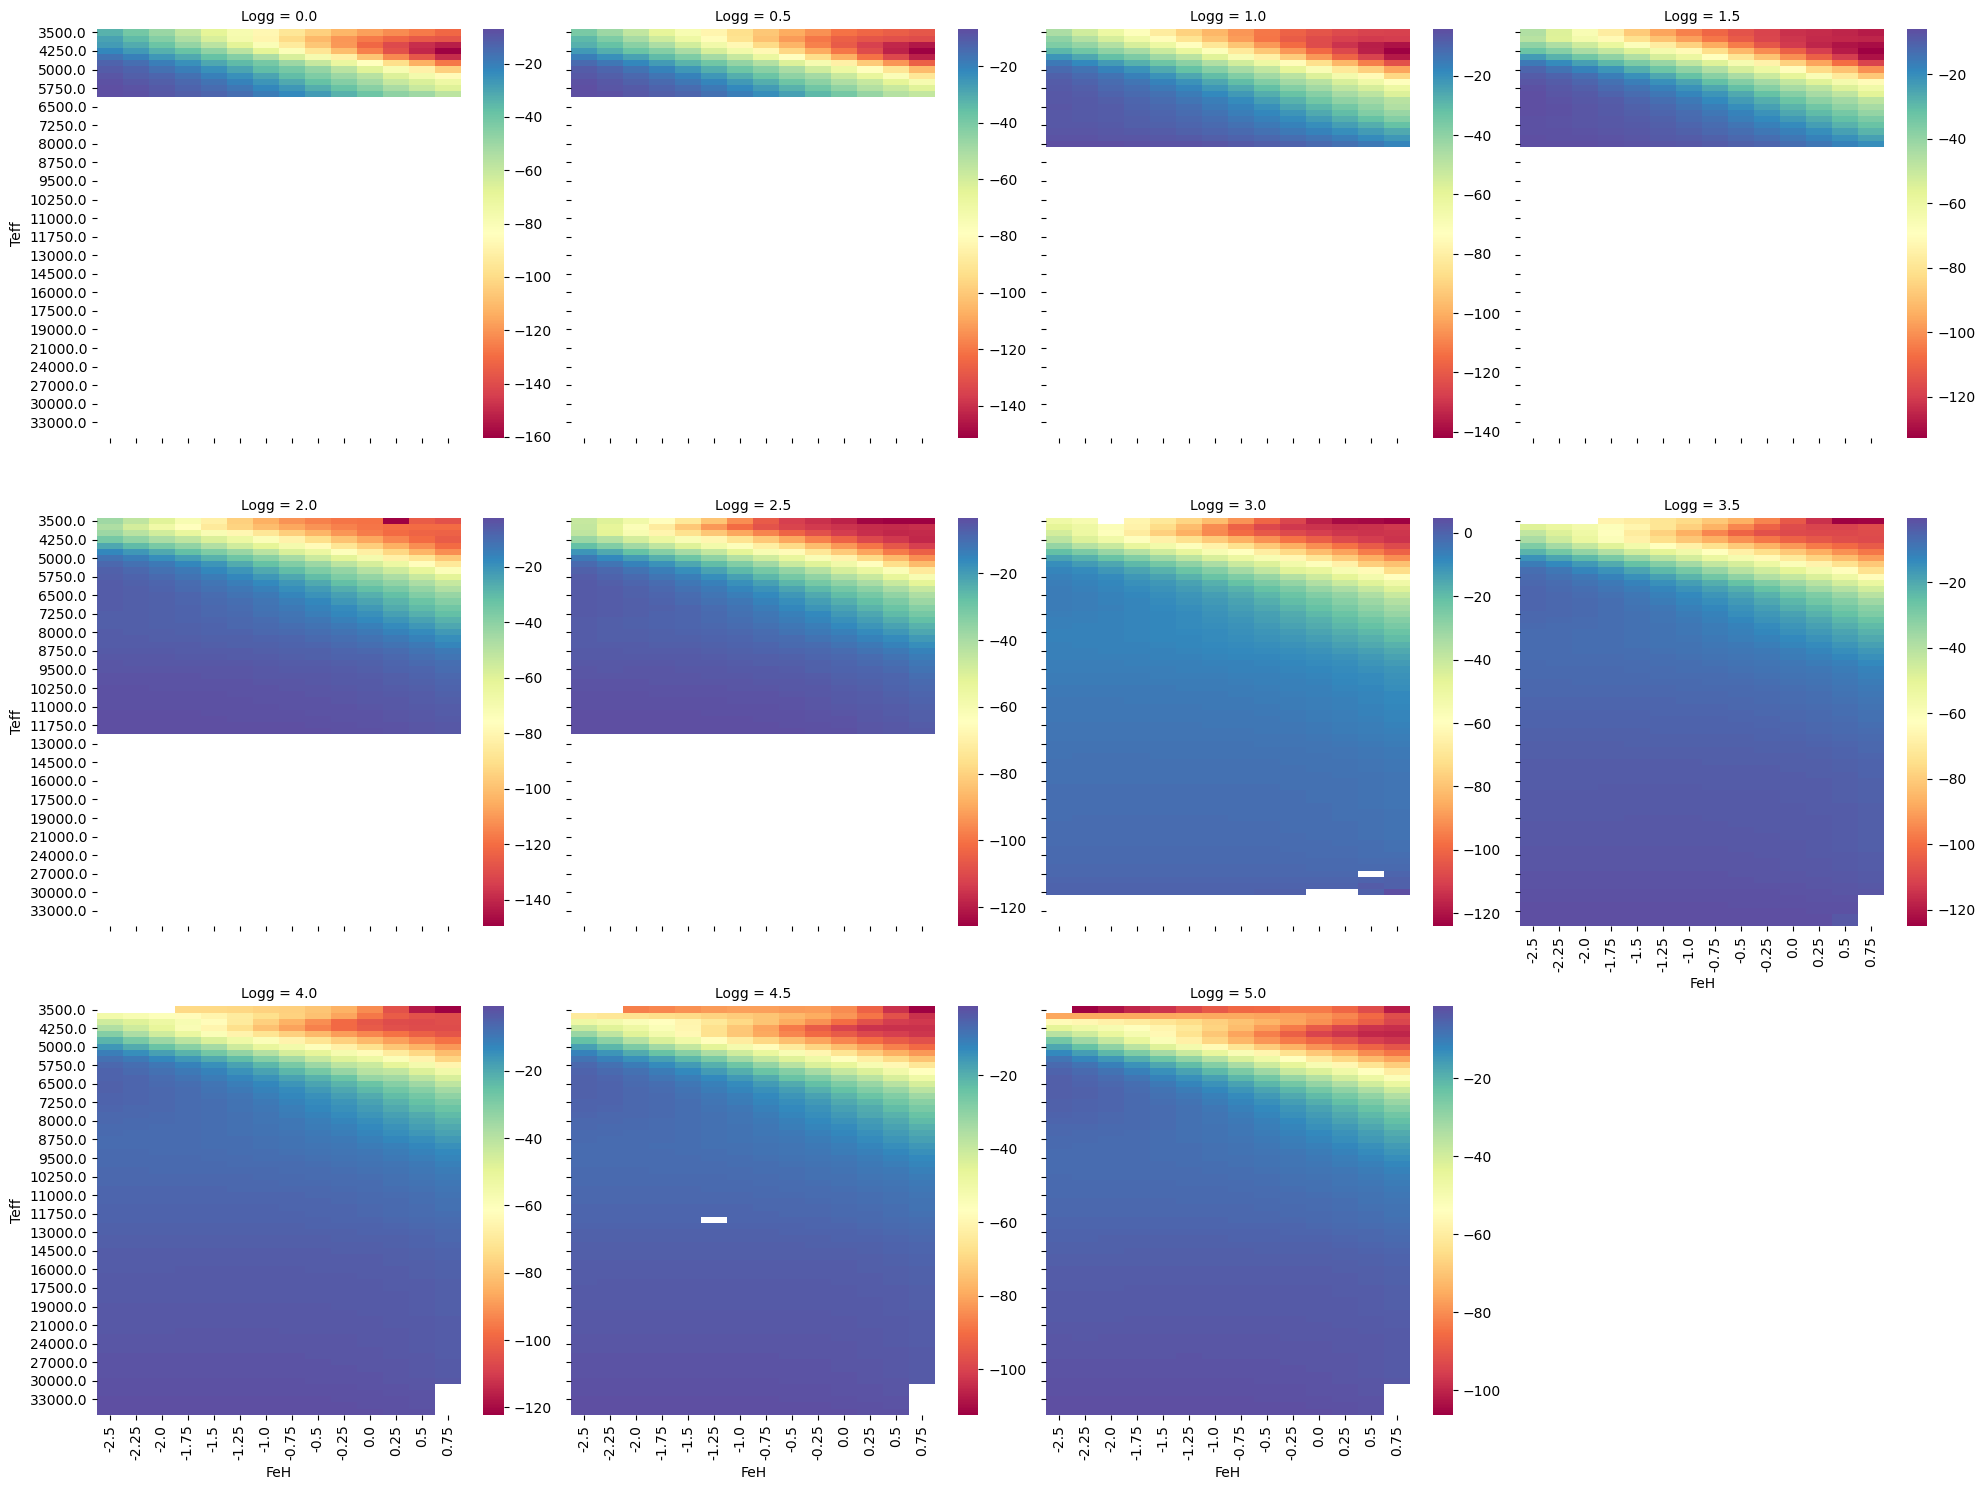

In [195]:
plot_PC_in_paras(data, pc="p1", save=0)

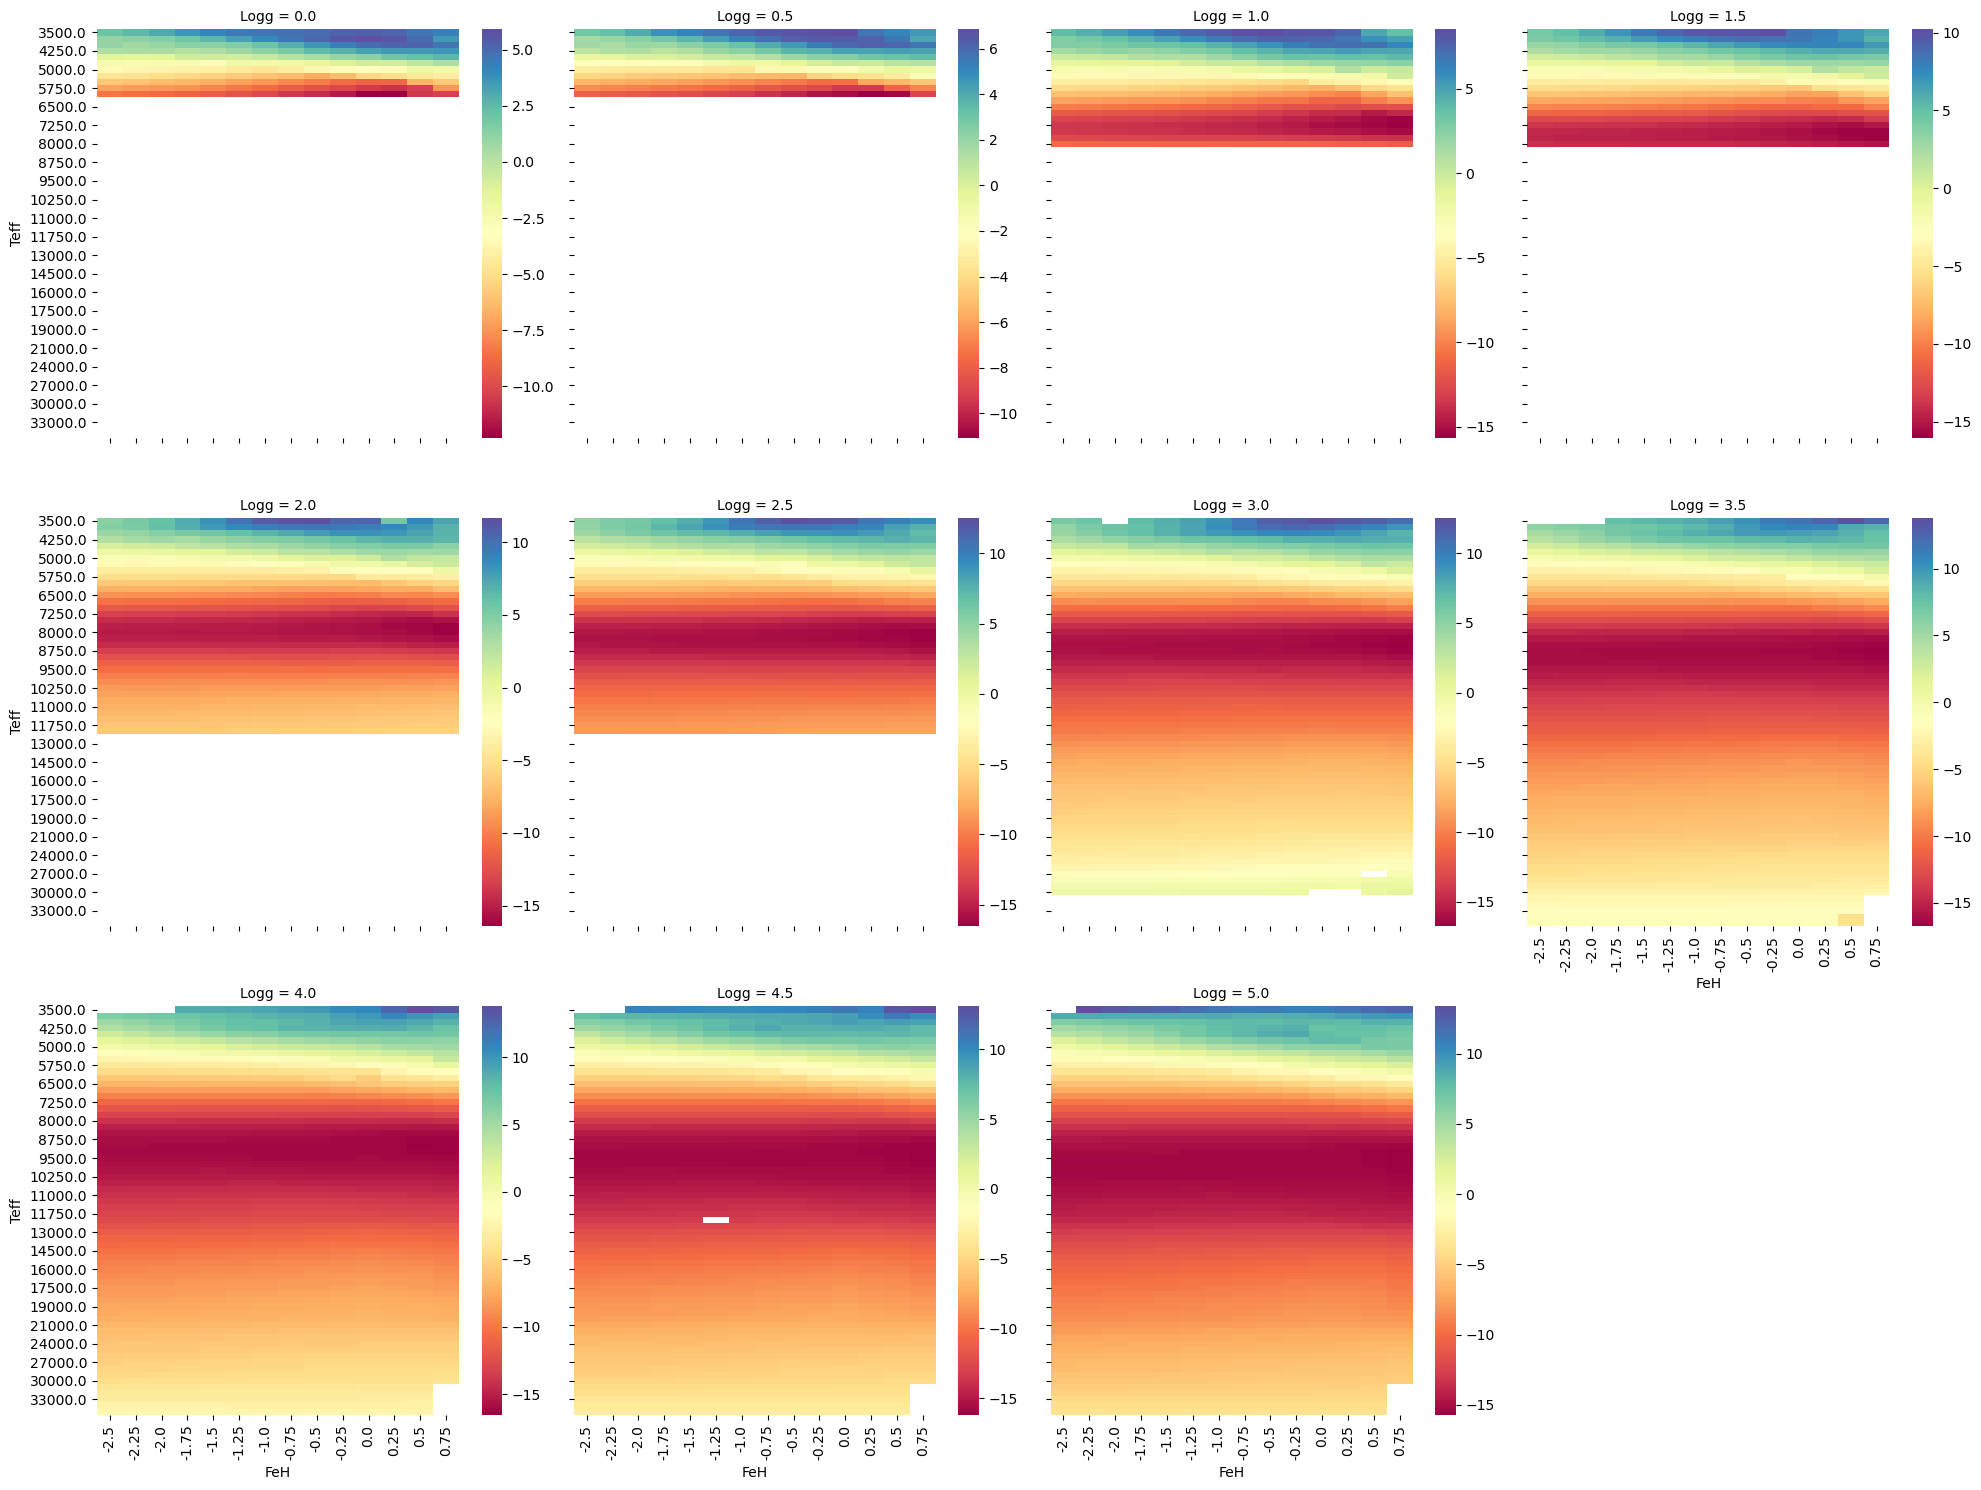

In [197]:
plot_PC_in_paras(data, pc="p2", save=1)

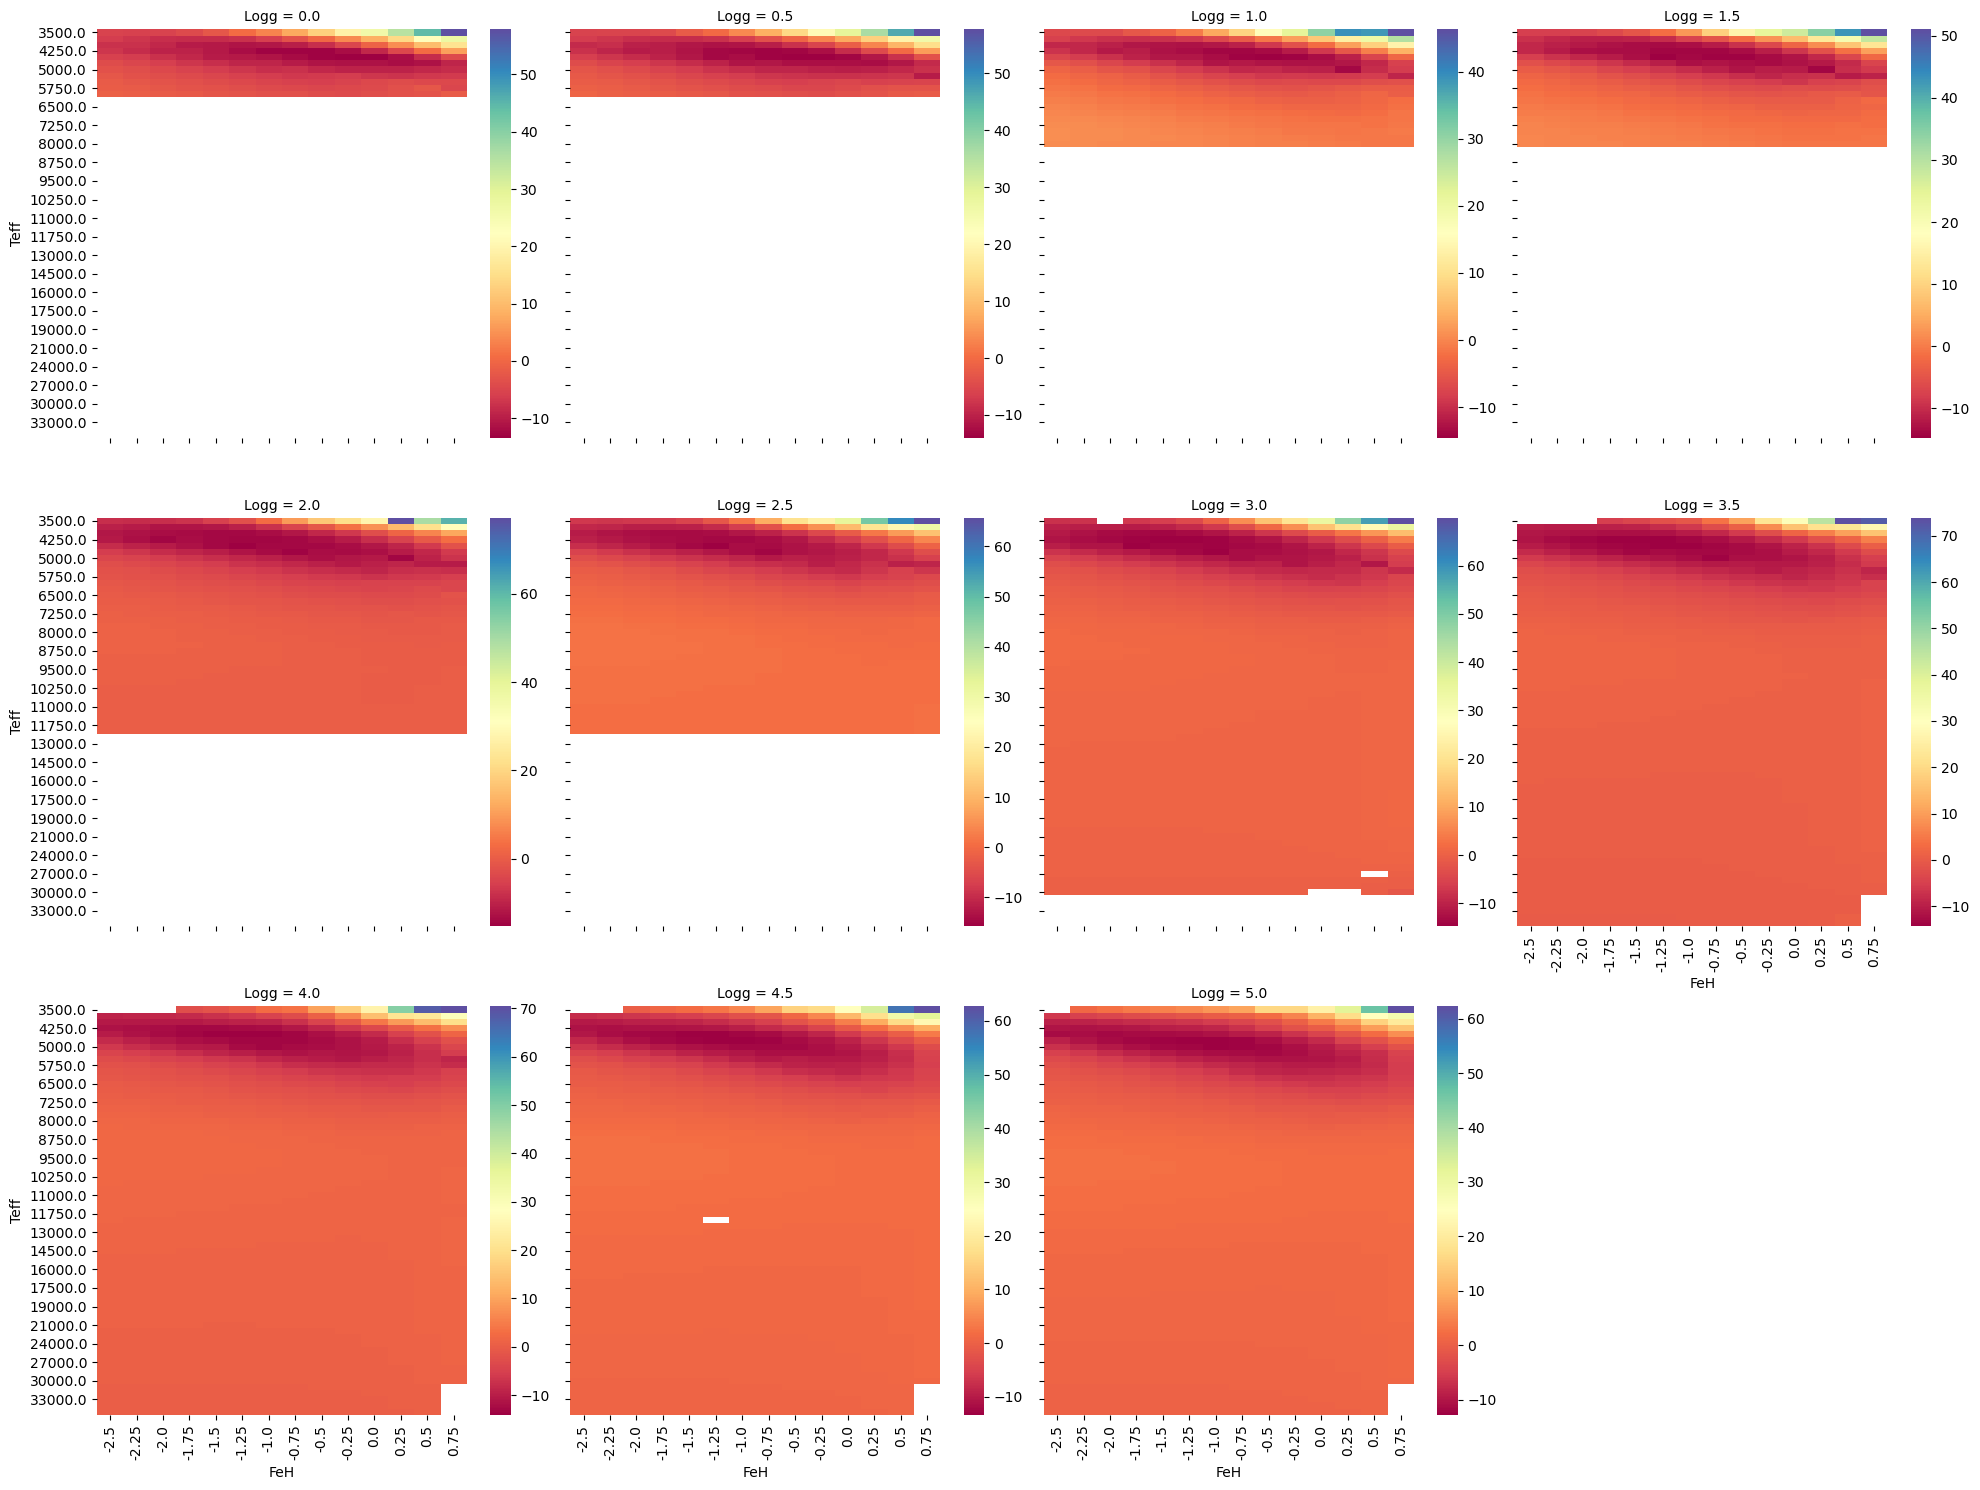

In [198]:
plot_PC_in_paras(data, pc="p3", save=1)

Text(0.5, 1.0, 'P1  @  Log_g=0')

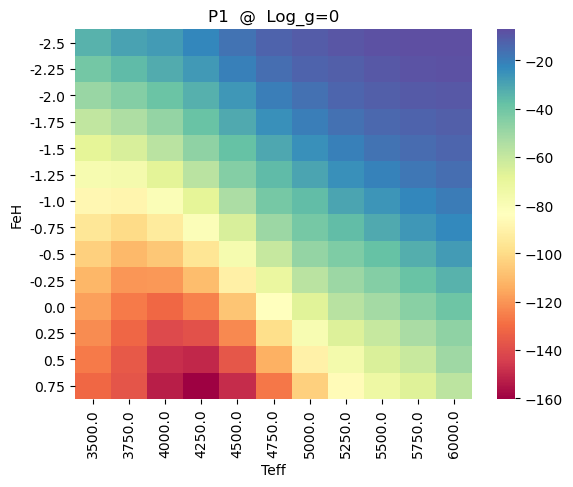

In [170]:
sns.heatmap(df_pivot, cmap="Spectral")
plt.title("P1  @  Log_g=0")

In [ ]:
plot_PC_in_paras(data, pc="p1", save=0)

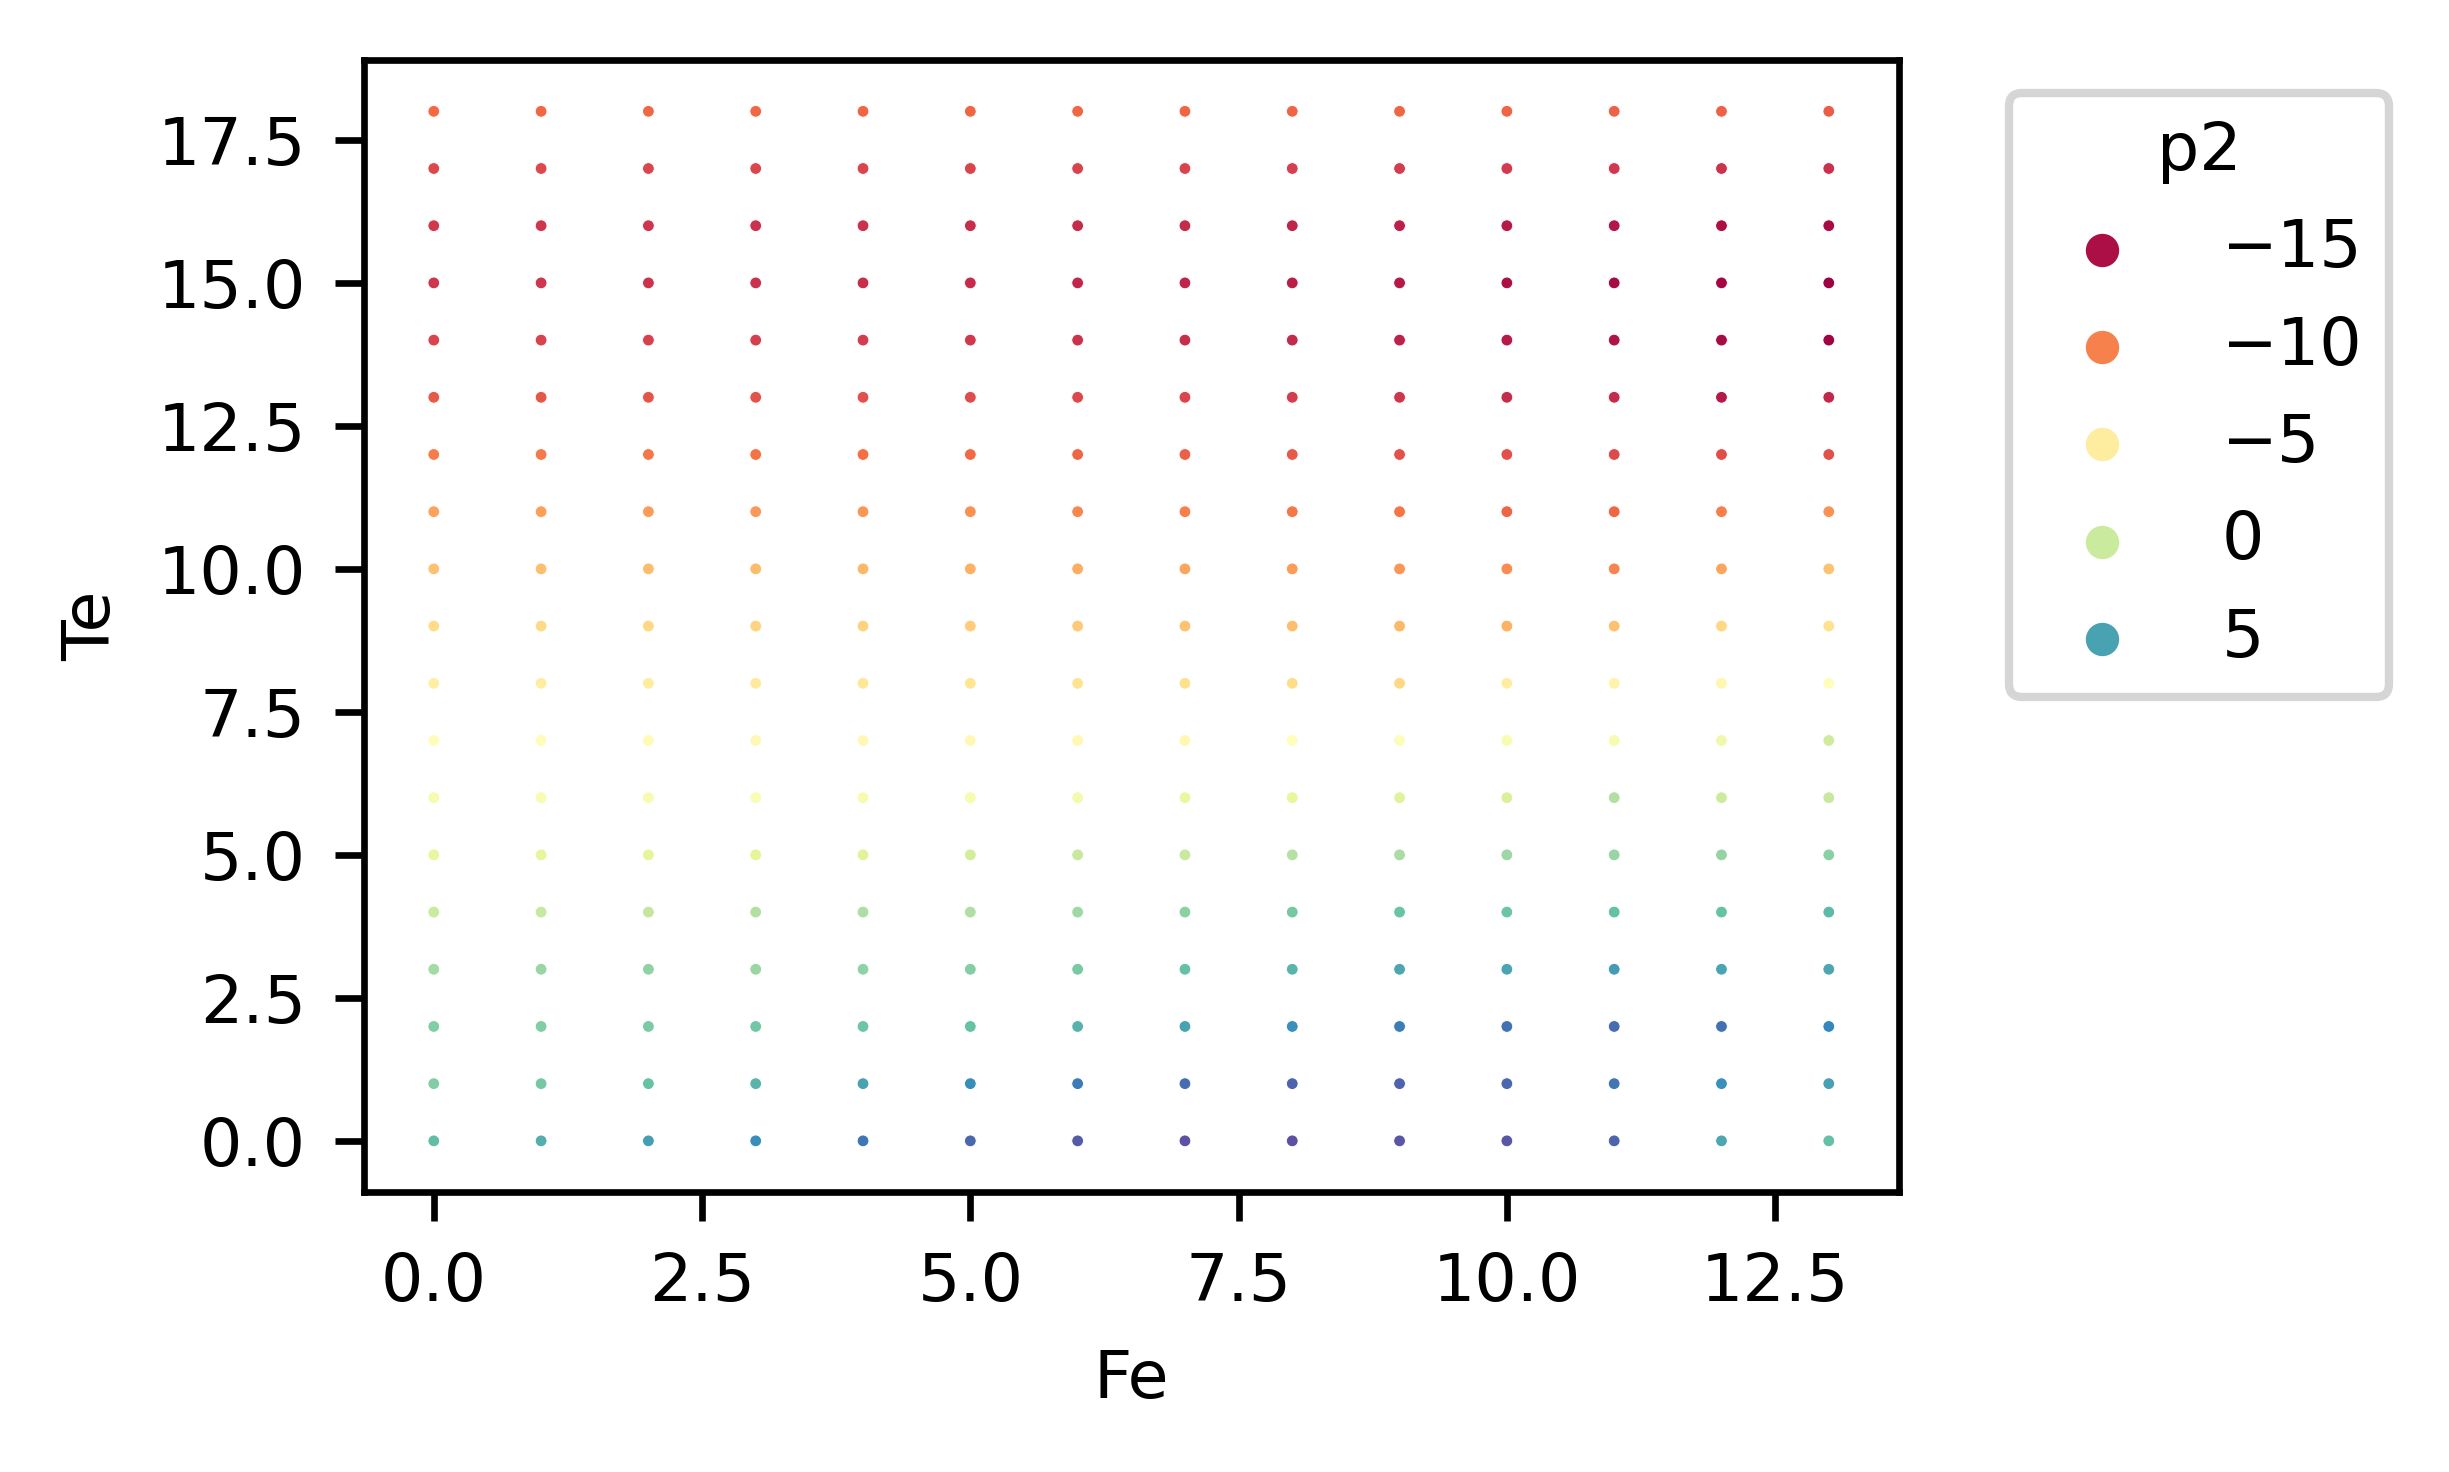

In [129]:
sns.scatterplot( "Fe", "Te", data=para00,hue="p2", palette="Spectral", s=2, )
plt.legend(markerscale=0.5,bbox_to_anchor=(1.05, 1),title="p2",)

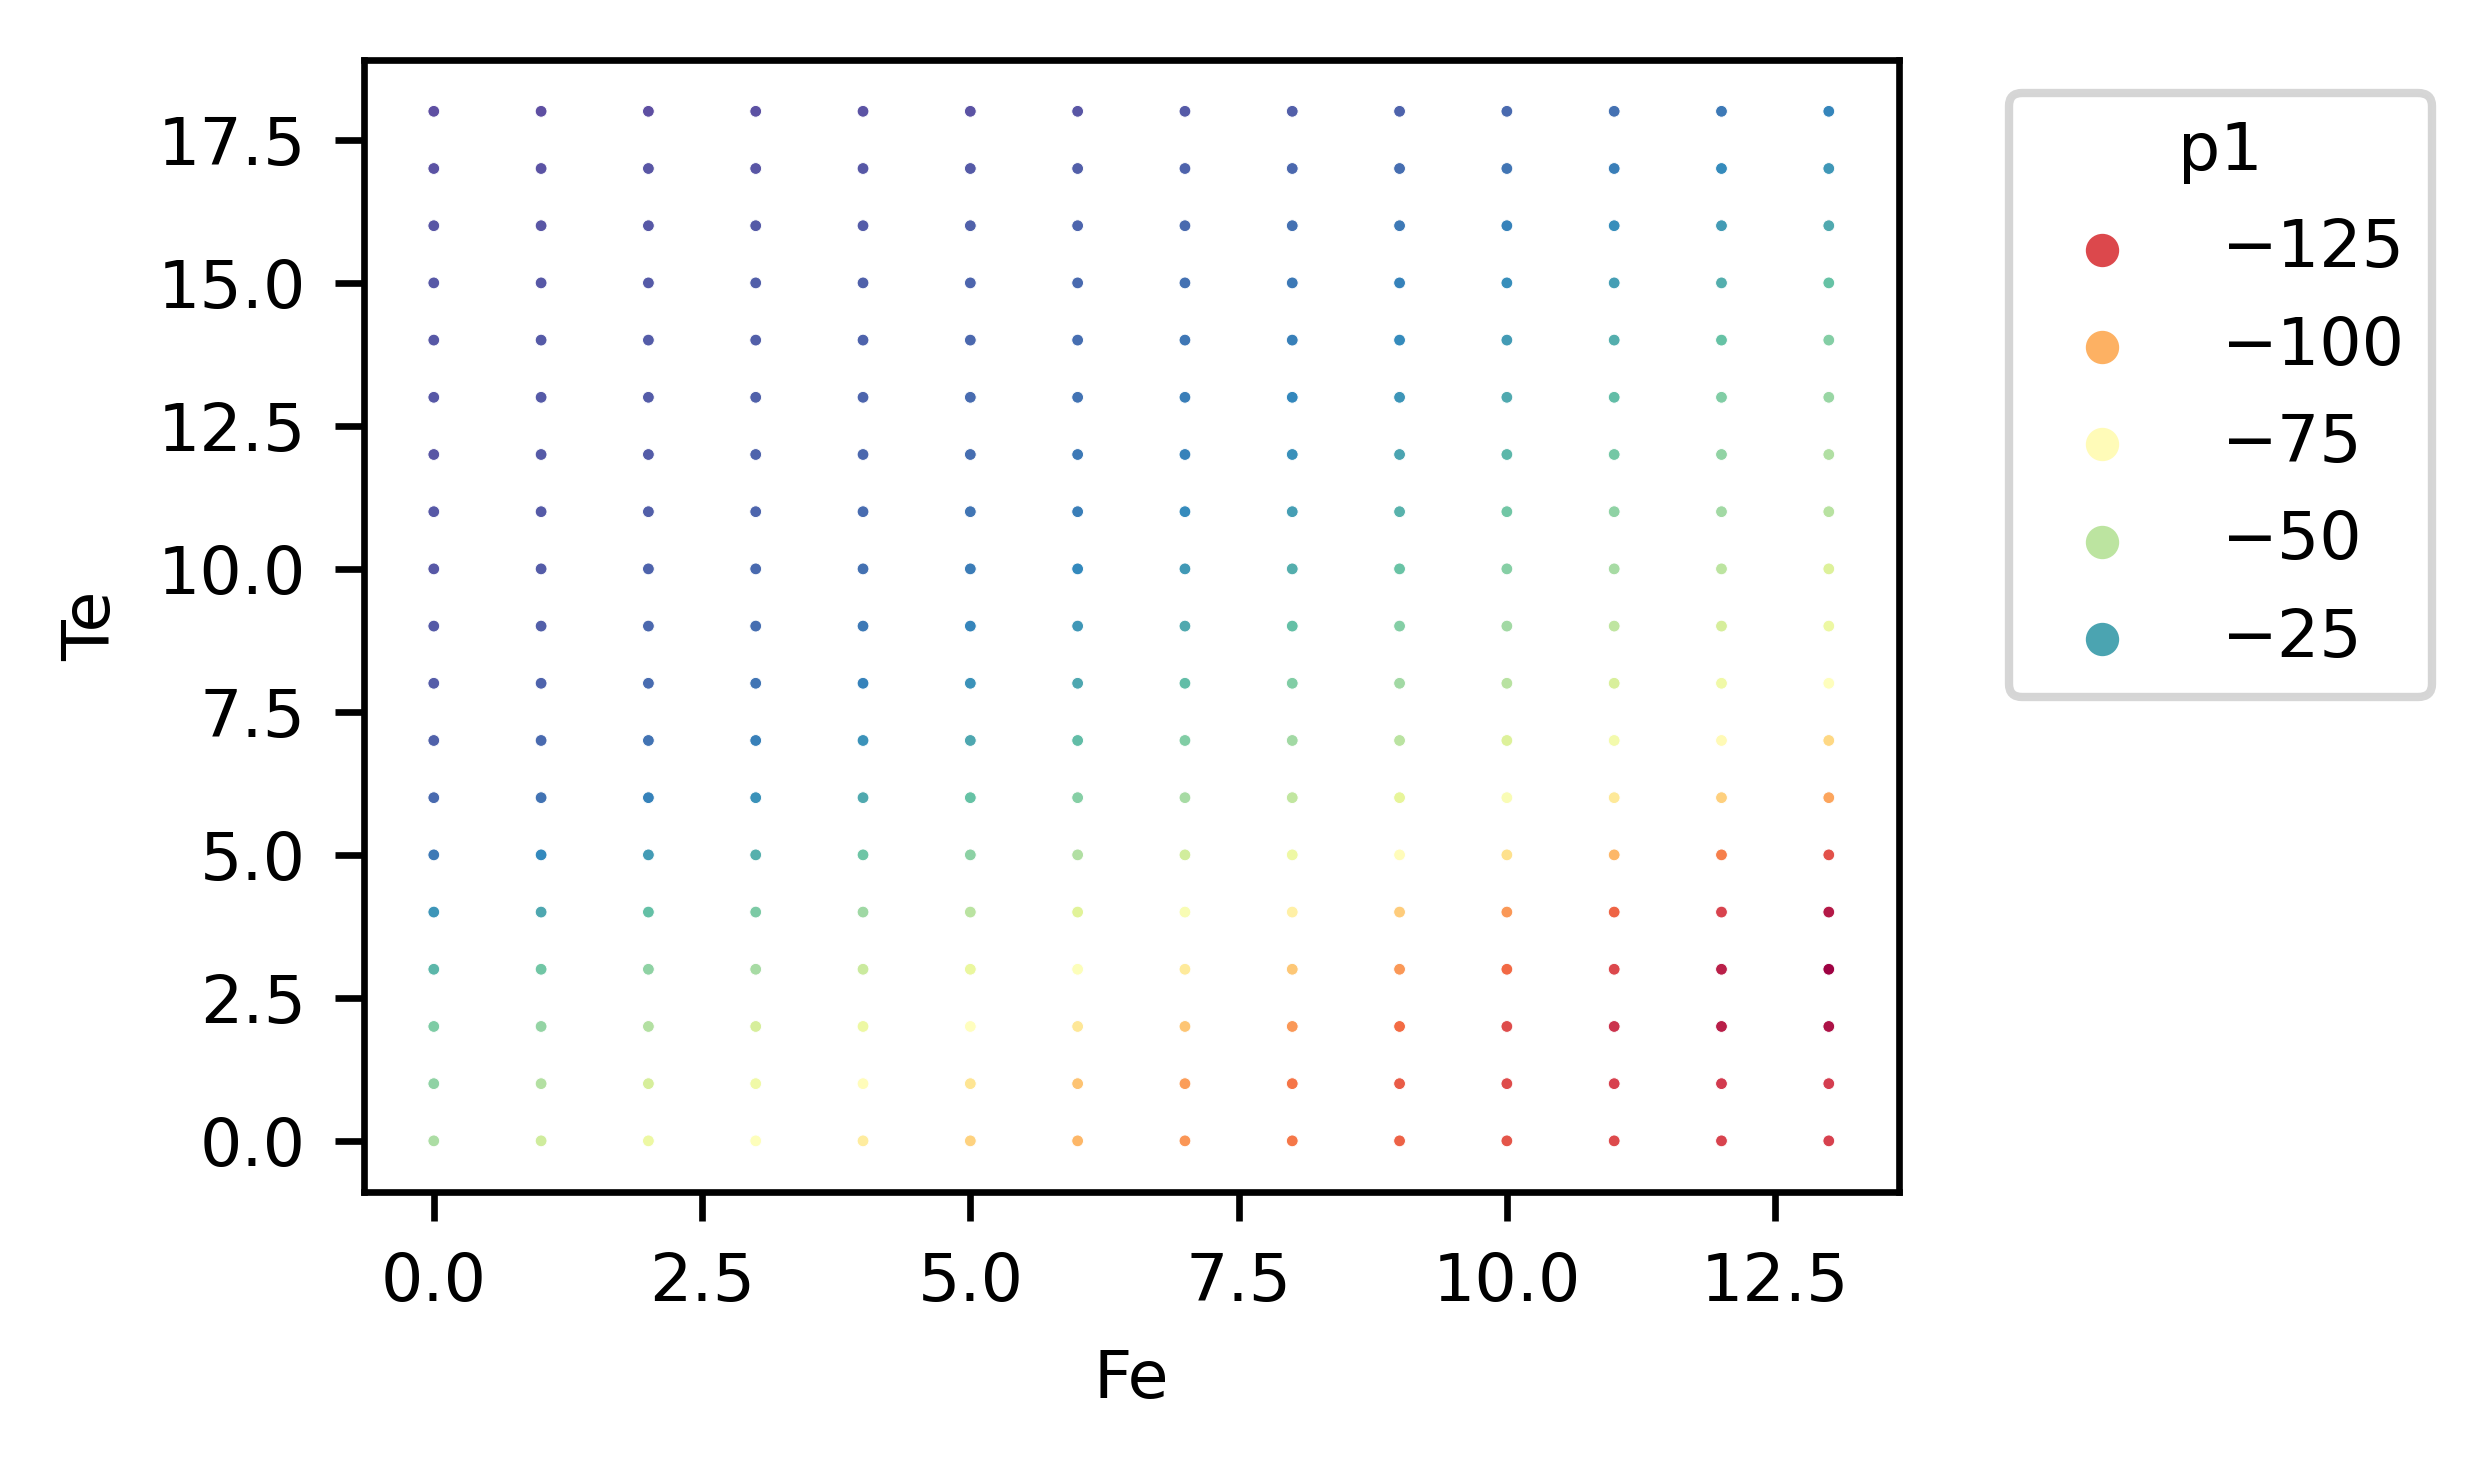

In [127]:
sns.scatterplot( "Fe", "Te", data=para00,hue="p1", palette="Spectral", s=2, )
plt.legend(markerscale=0.5,bbox_to_anchor=(1.05, 1),title="p1",)

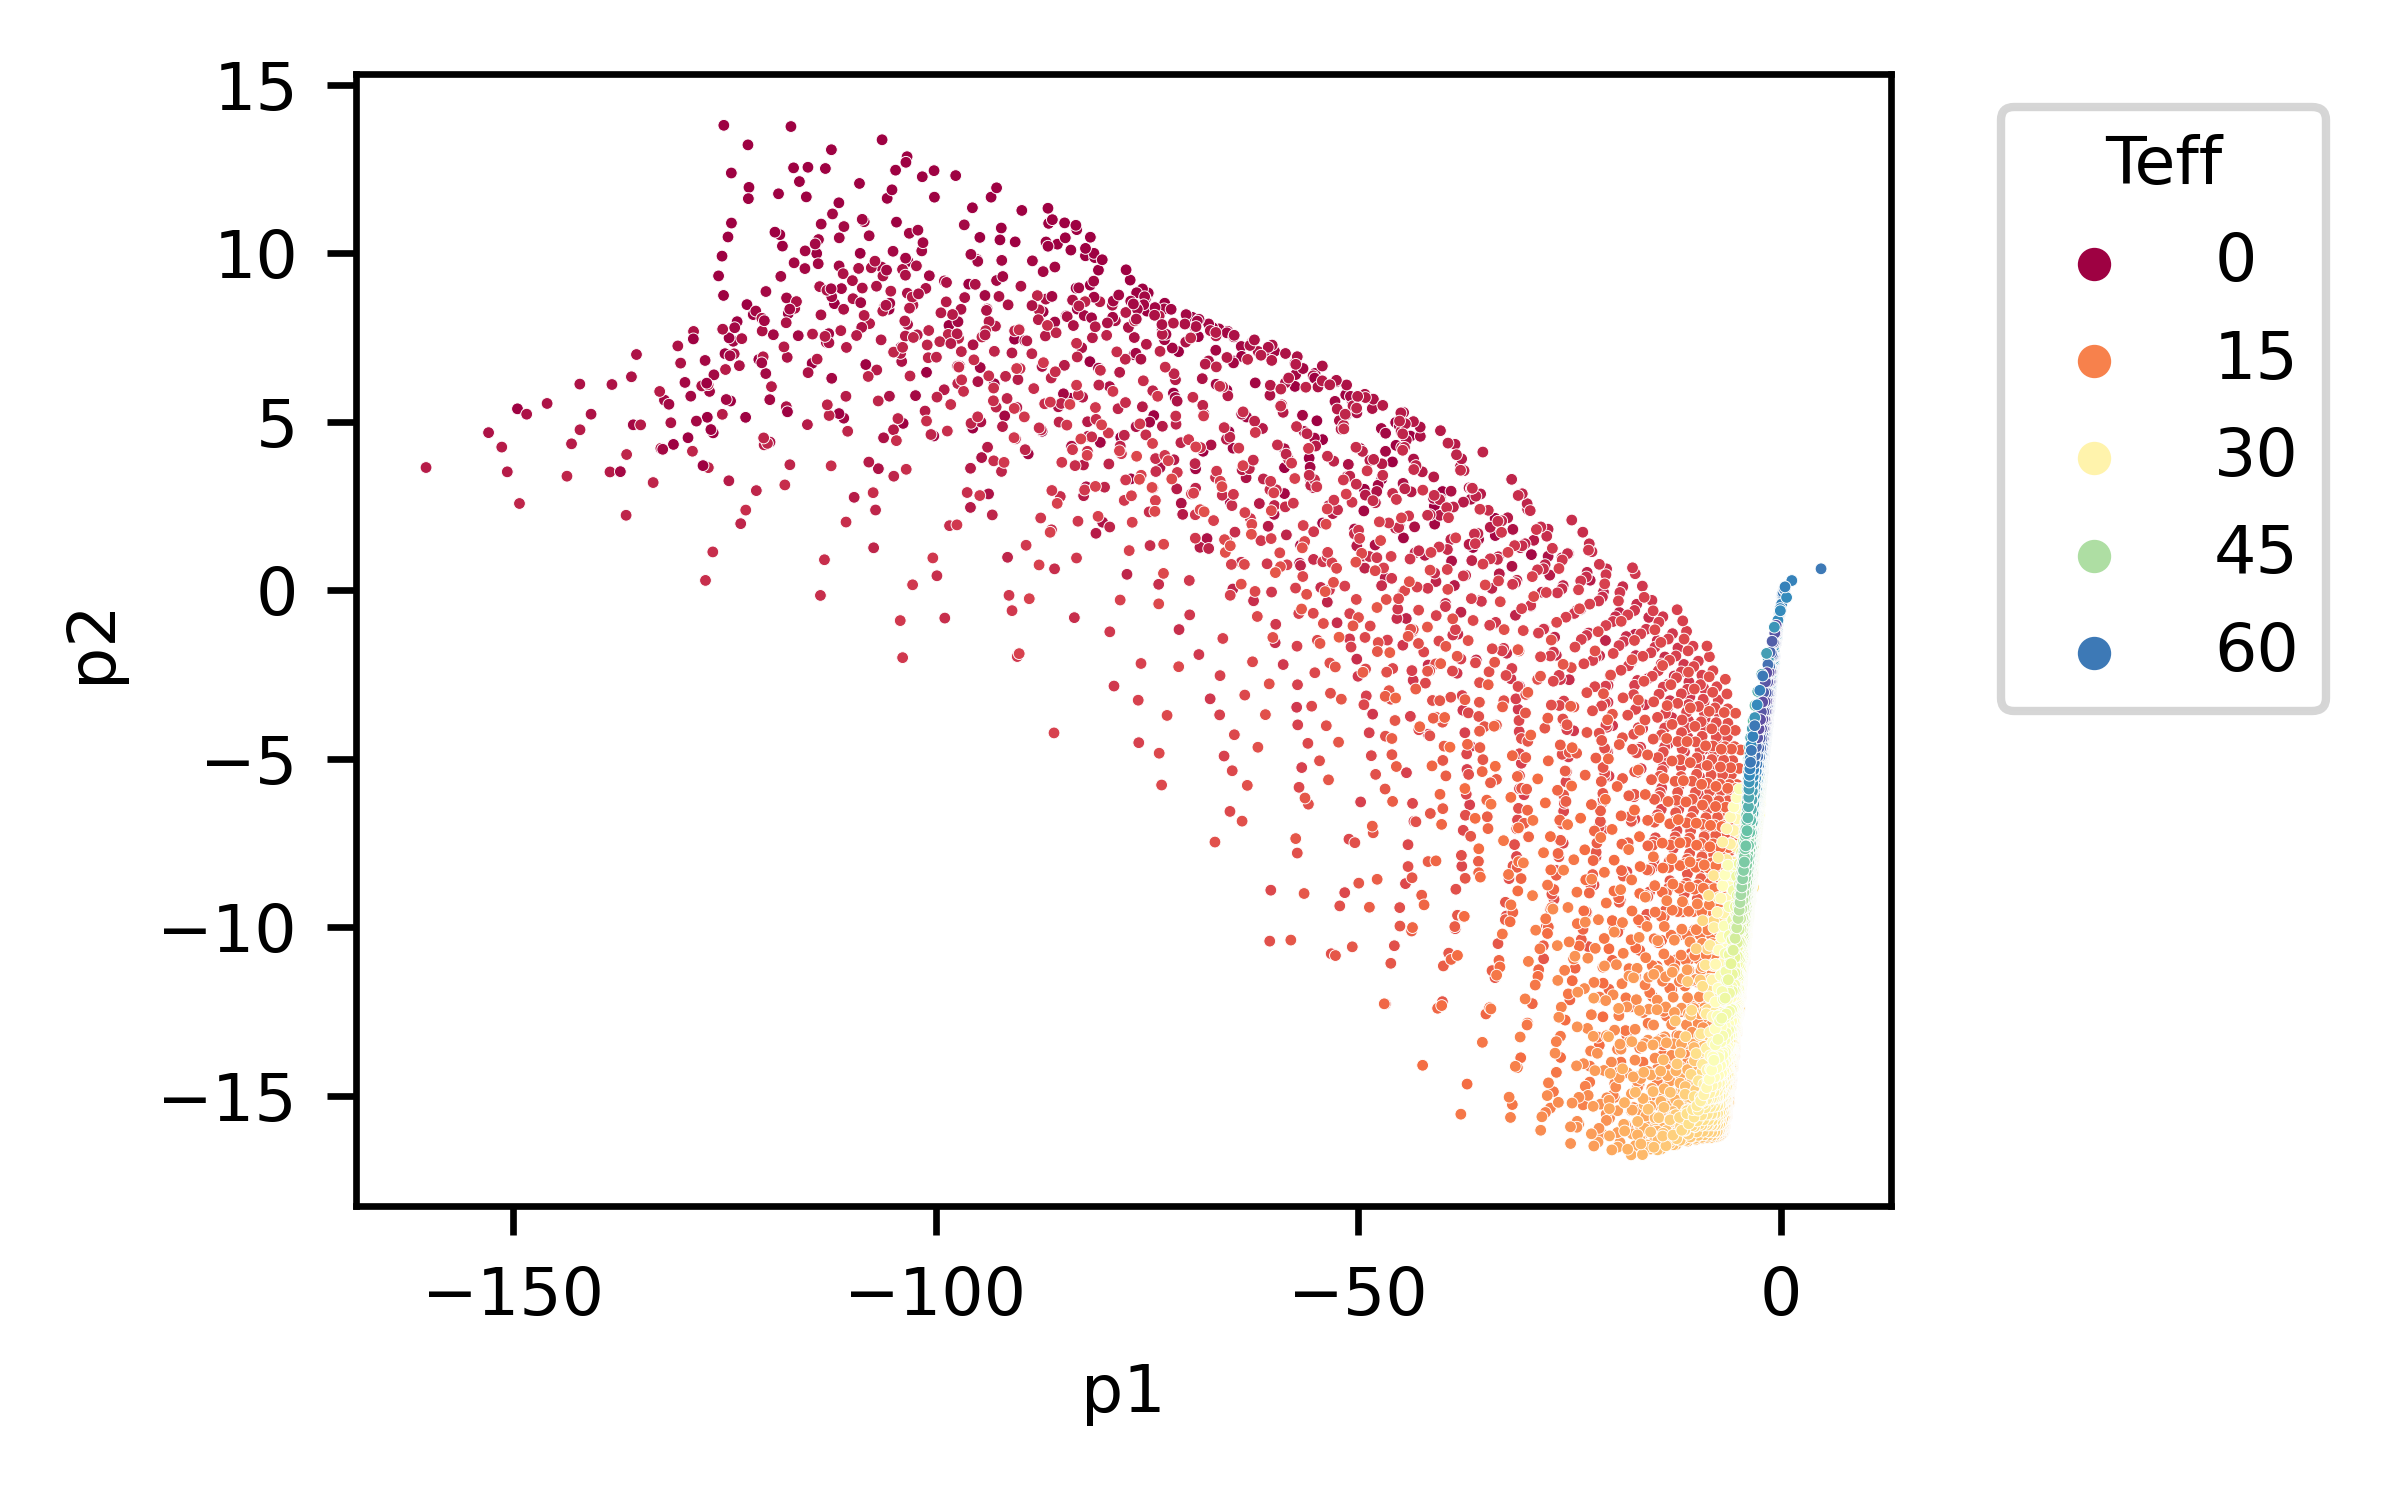

In [115]:
sns.scatterplot( "p1", "p2", data=para0,hue="Te", palette="Spectral", s=2, )
plt.legend(markerscale=0.5,bbox_to_anchor=(1.05, 1),title="Teff",)

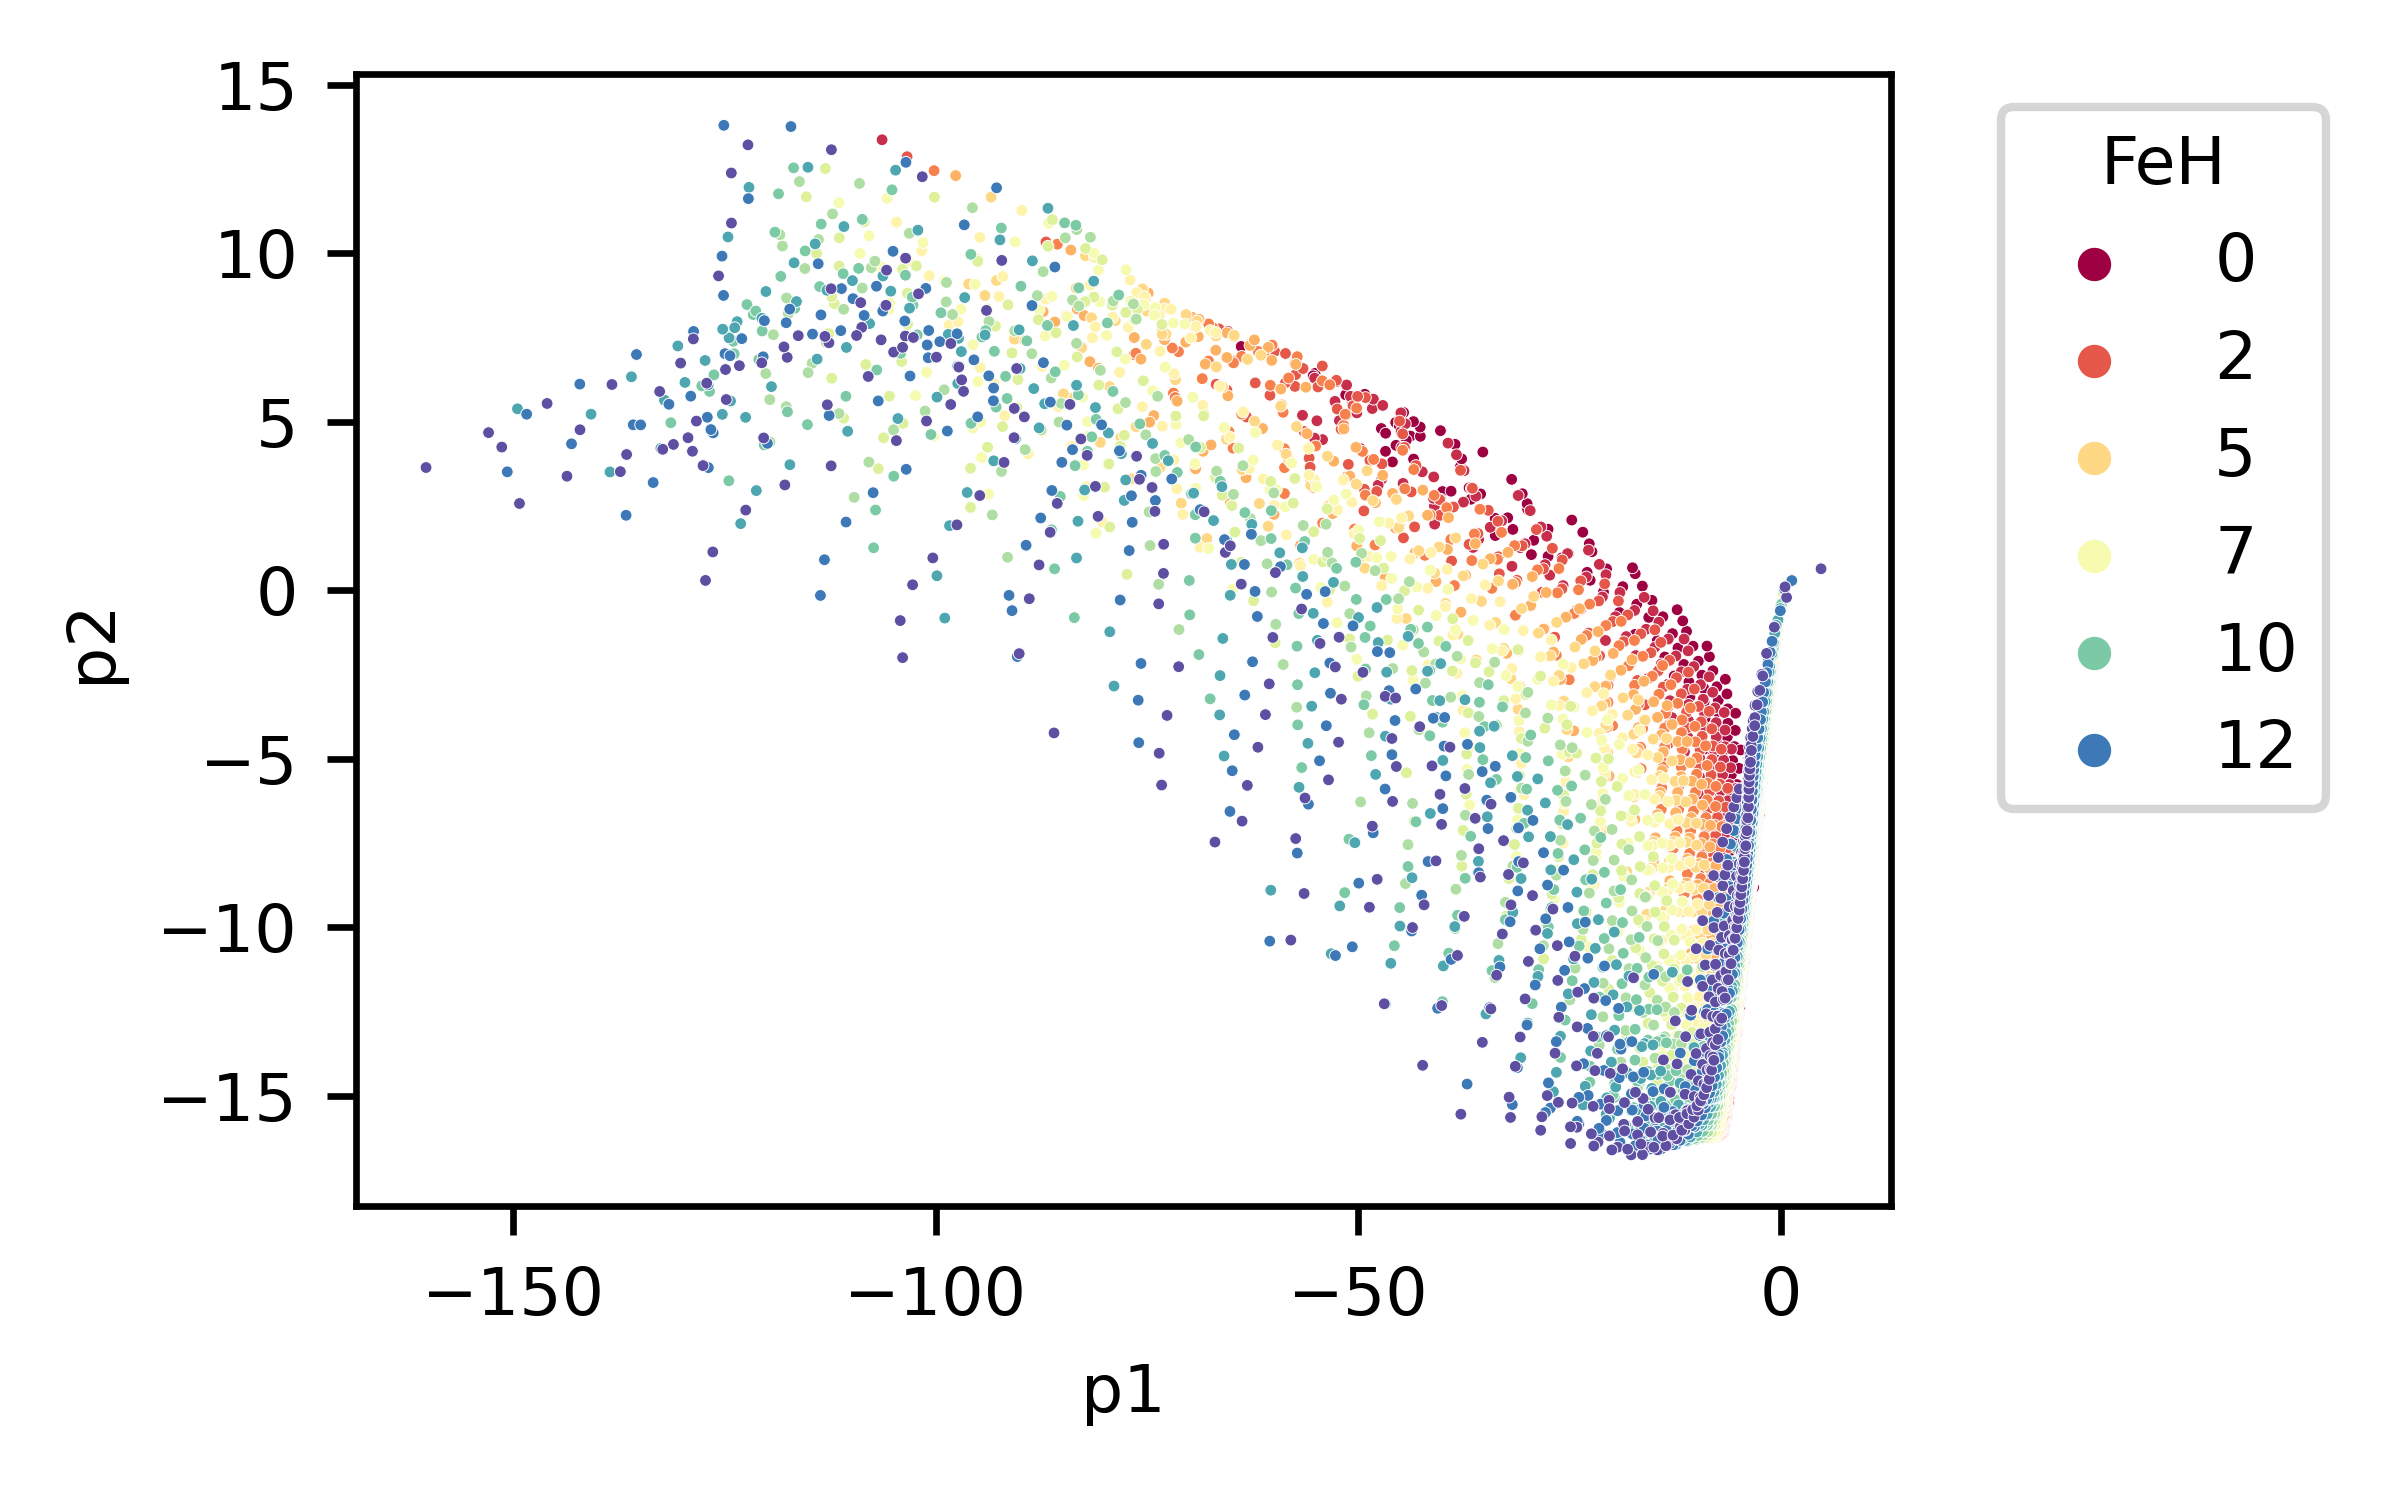

In [114]:
sns.scatterplot( "p1", "p2", data=para0,hue="Fe", palette="Spectral", s=2, )
plt.legend(markerscale=0.5,bbox_to_anchor=(1.05, 1),title="FeH",)

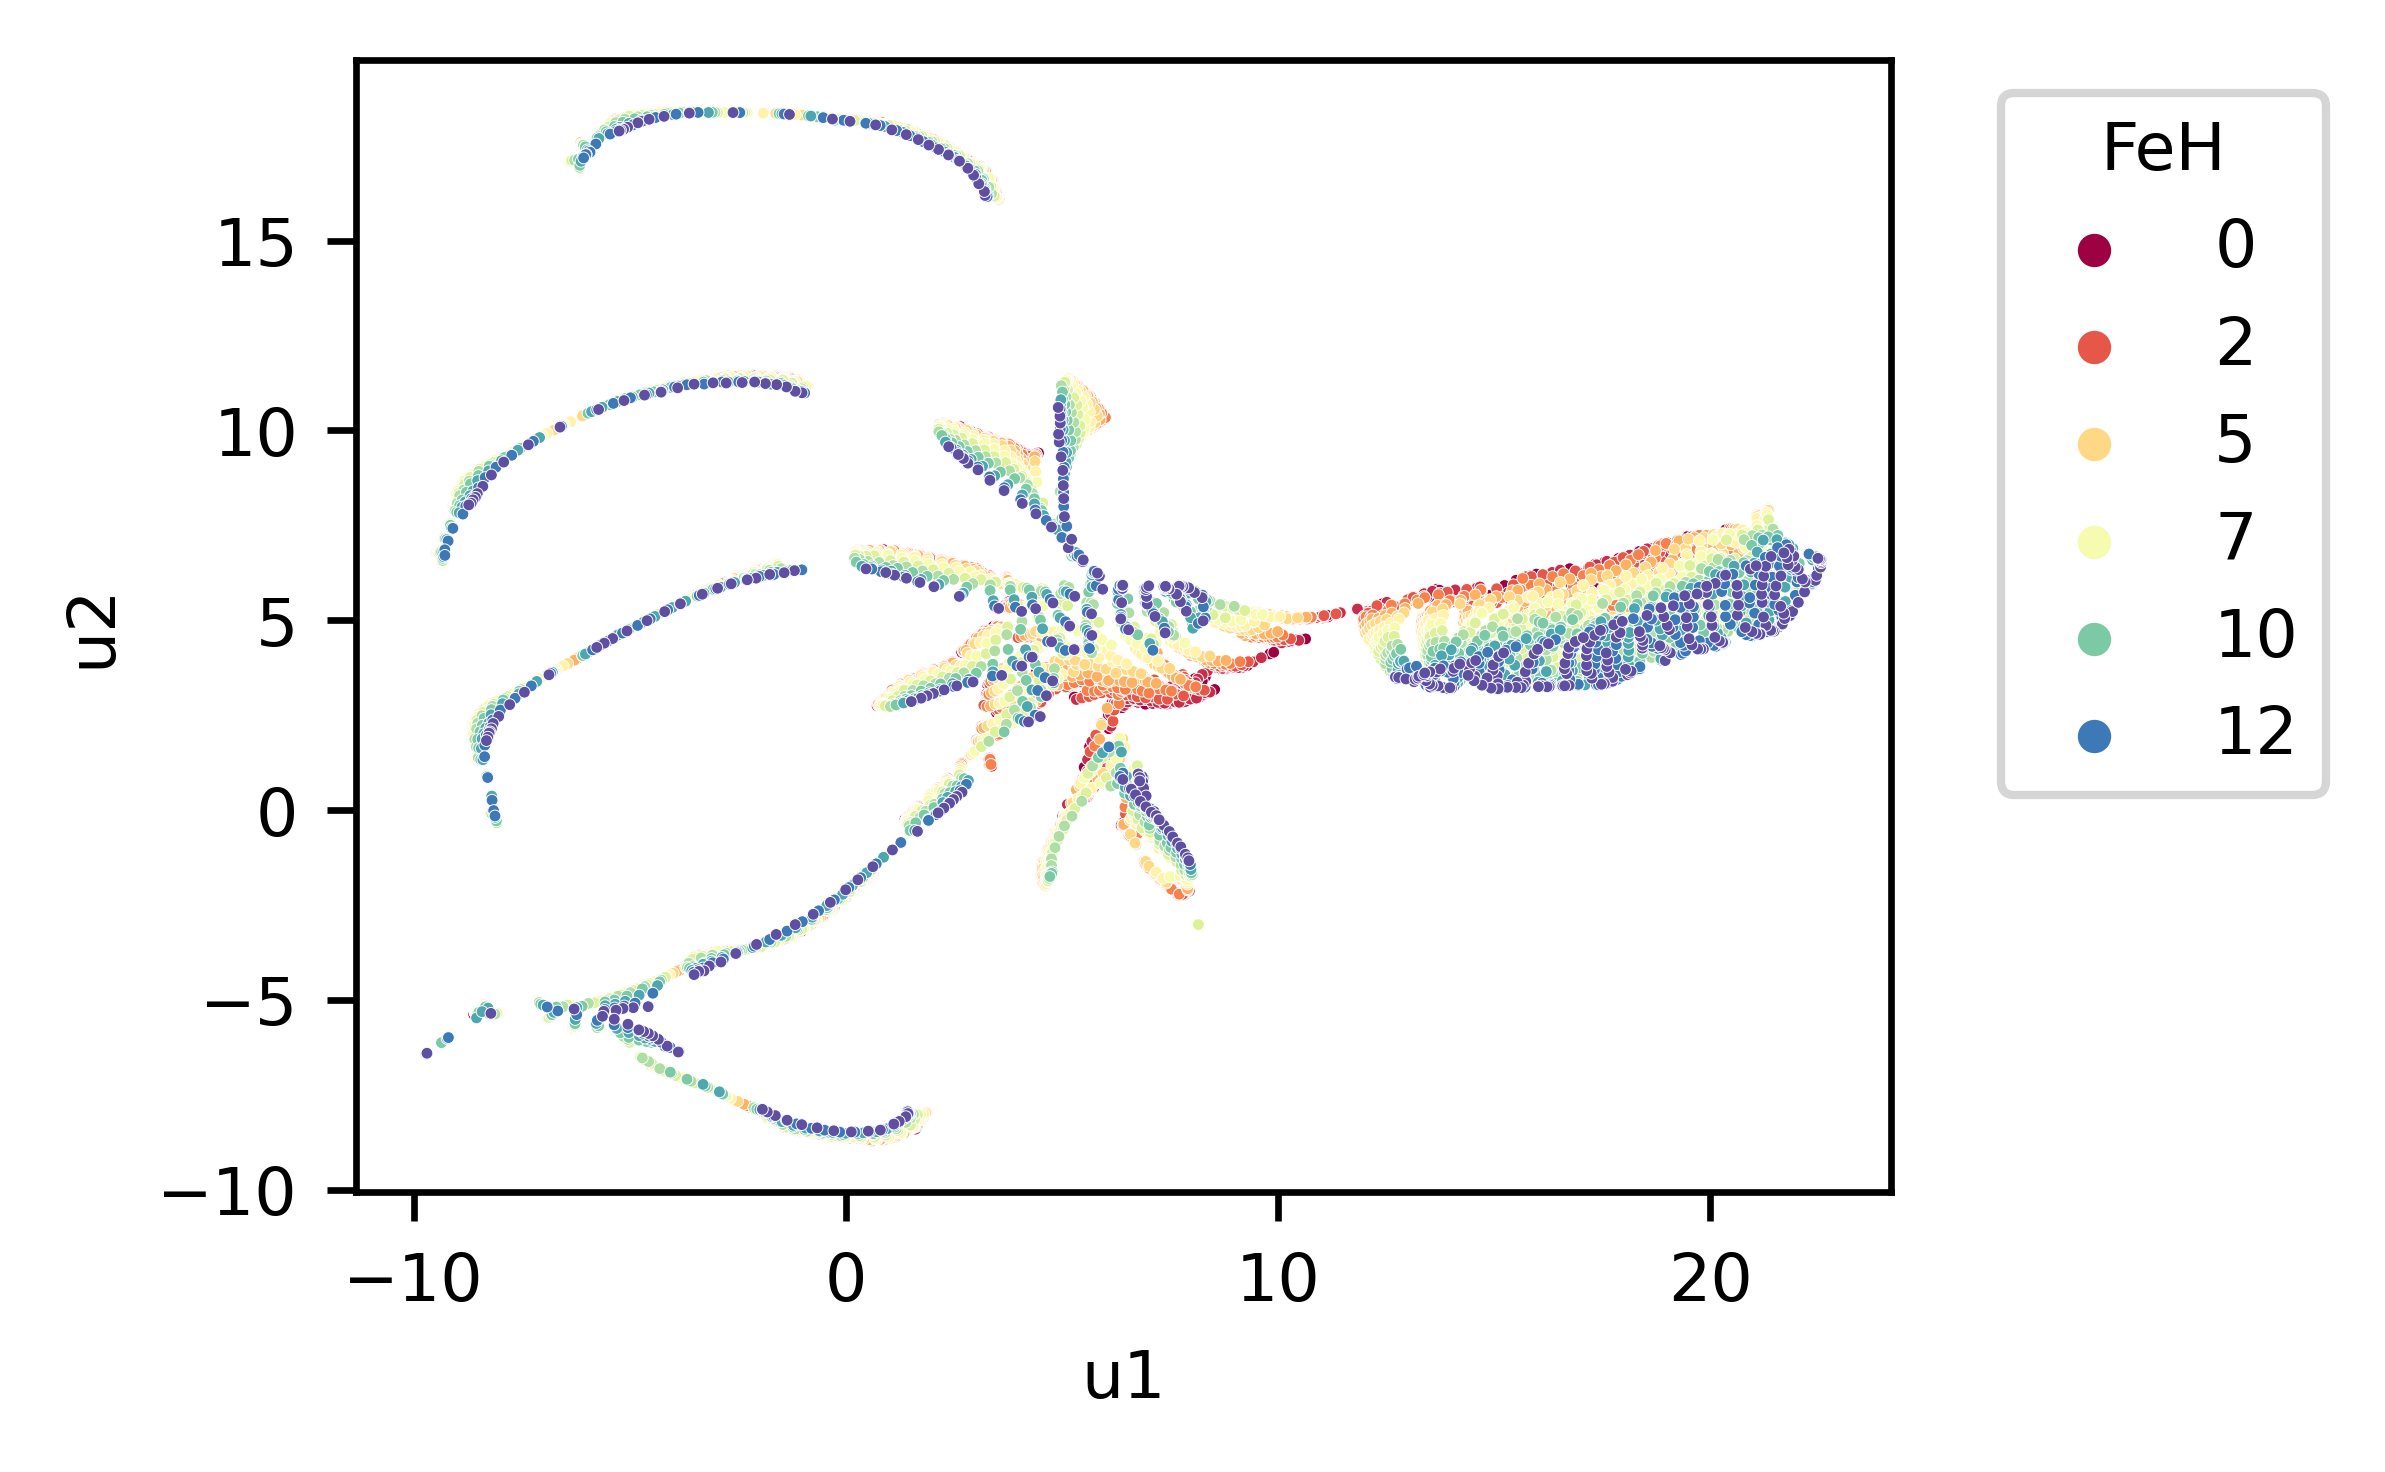

In [105]:
sns.scatterplot( "u1", "u2", data=para0,hue="Fe", palette="Spectral", s=2, )
plt.legend(markerscale=0.5,bbox_to_anchor=(1.05, 1),title="FeH",)

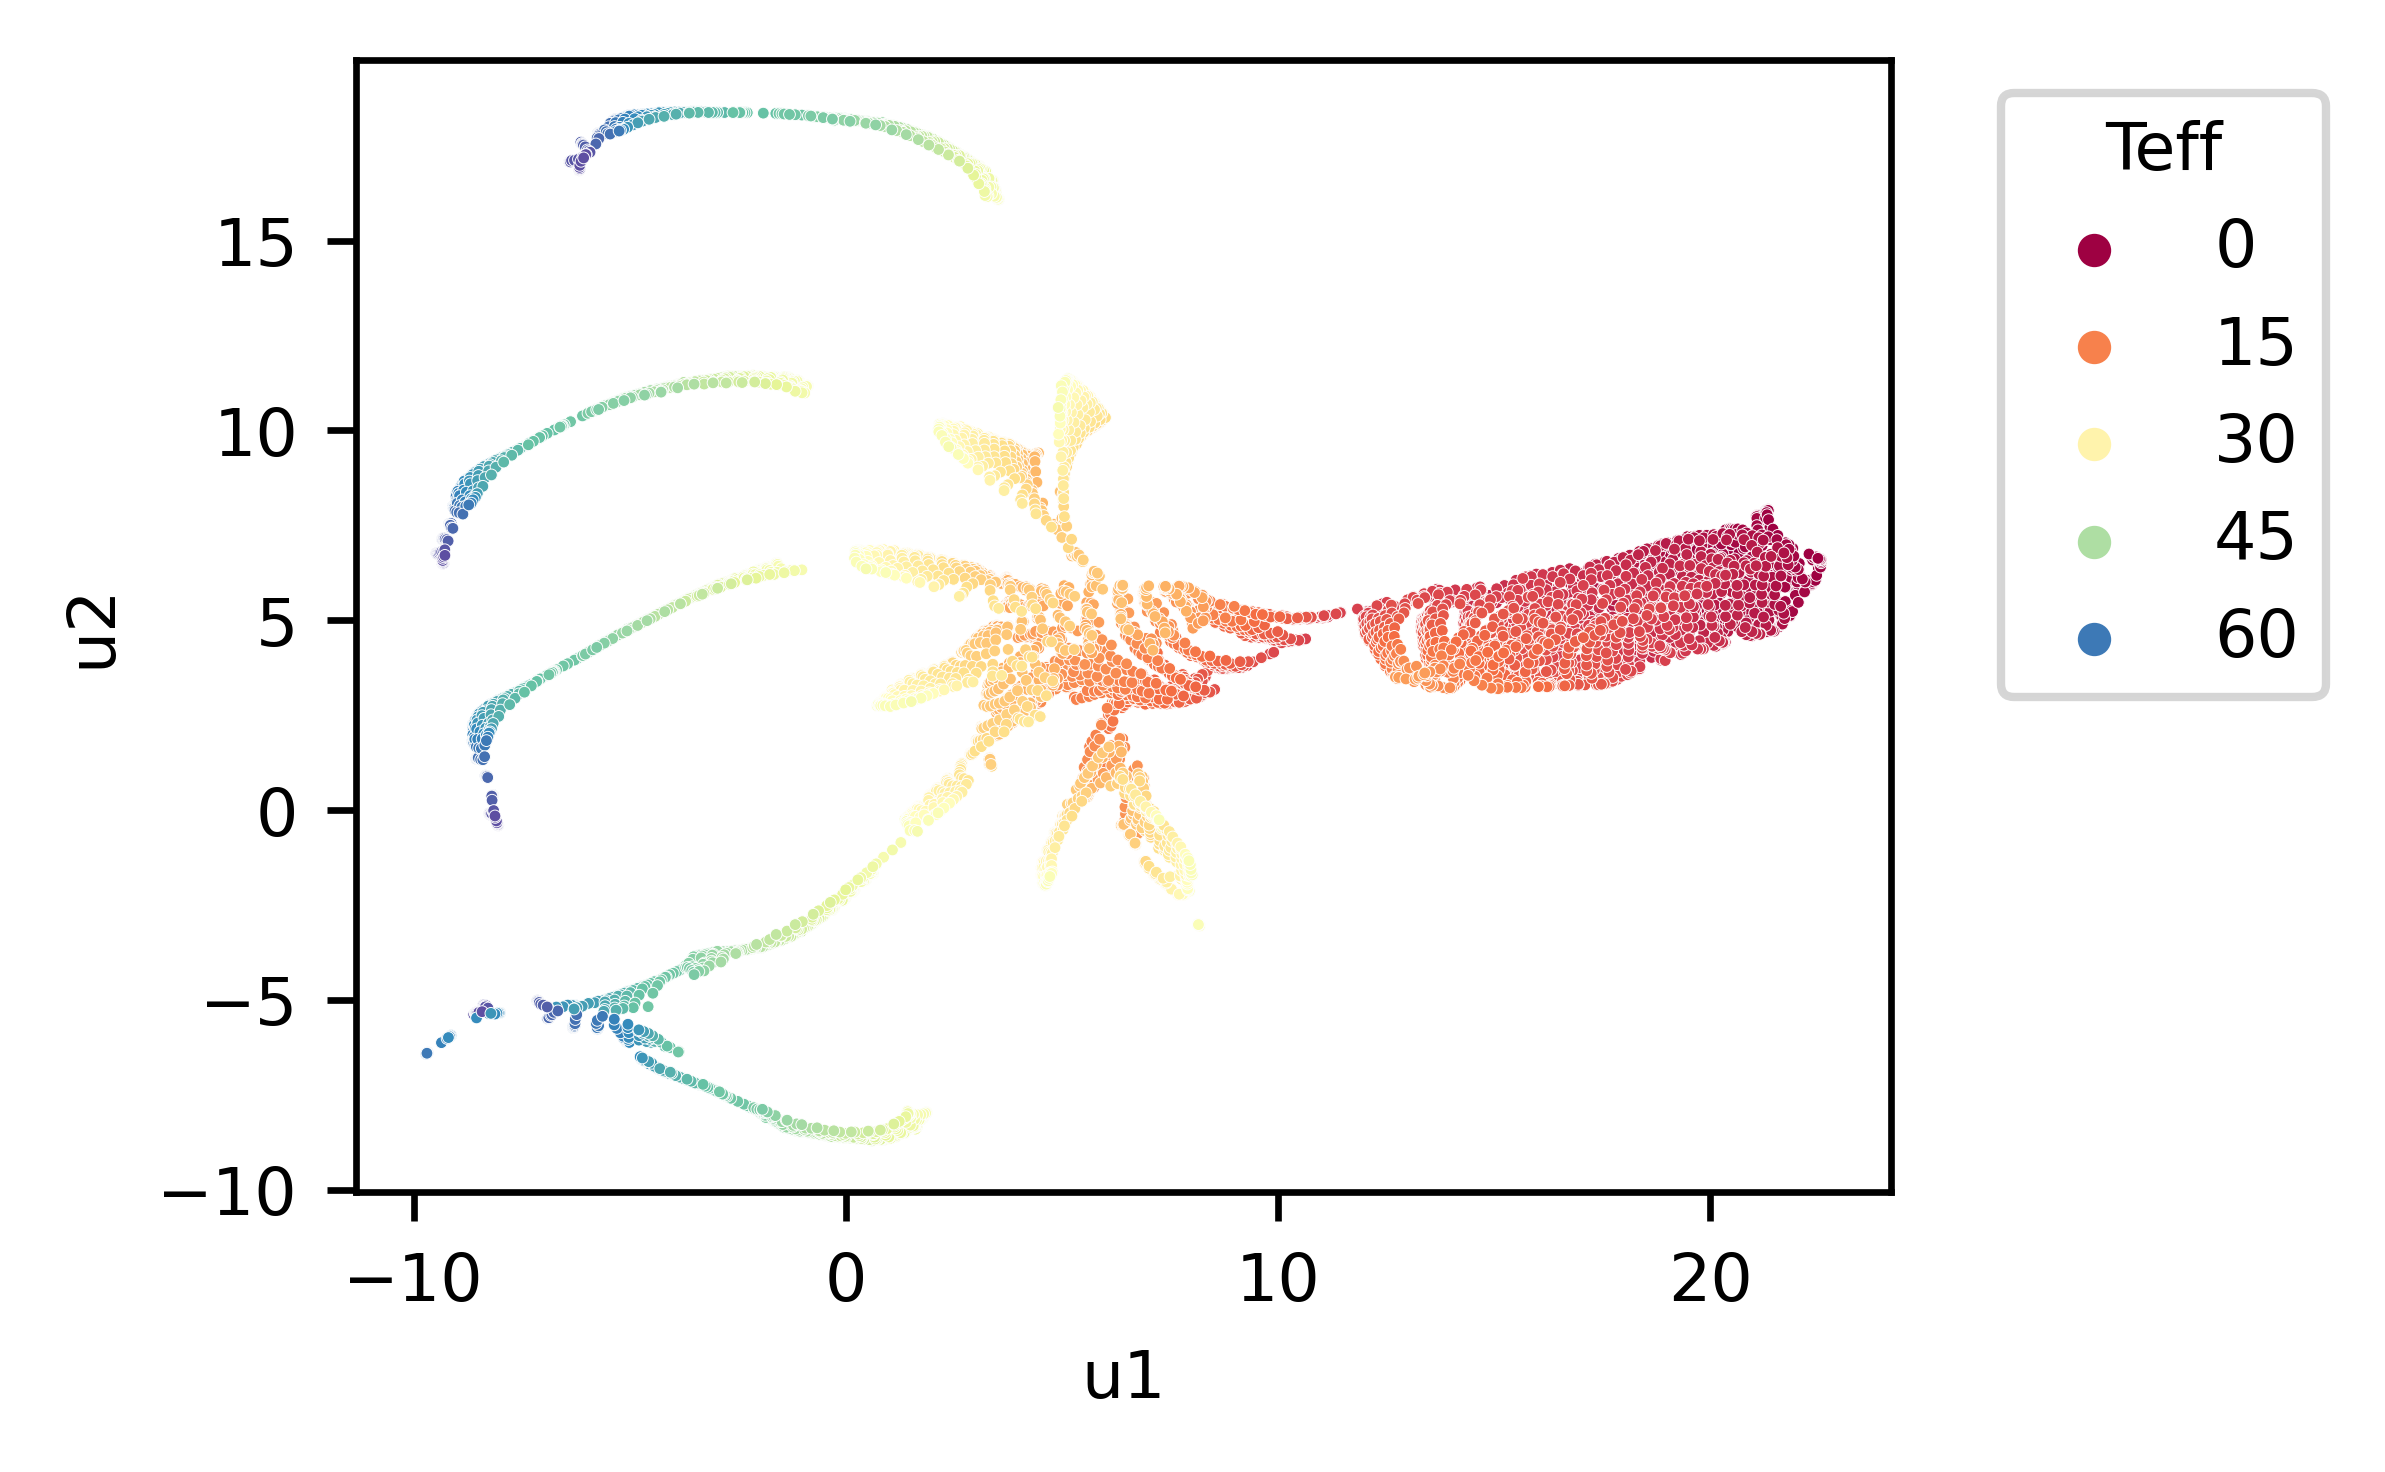

In [106]:
sns.scatterplot( "u1", "u2", data=para0,hue="Te", palette="Spectral", s=2, )
plt.legend(markerscale=0.5,bbox_to_anchor=(1.05, 1),title="Teff",)

Text(0.5, 0, 'umap_2')

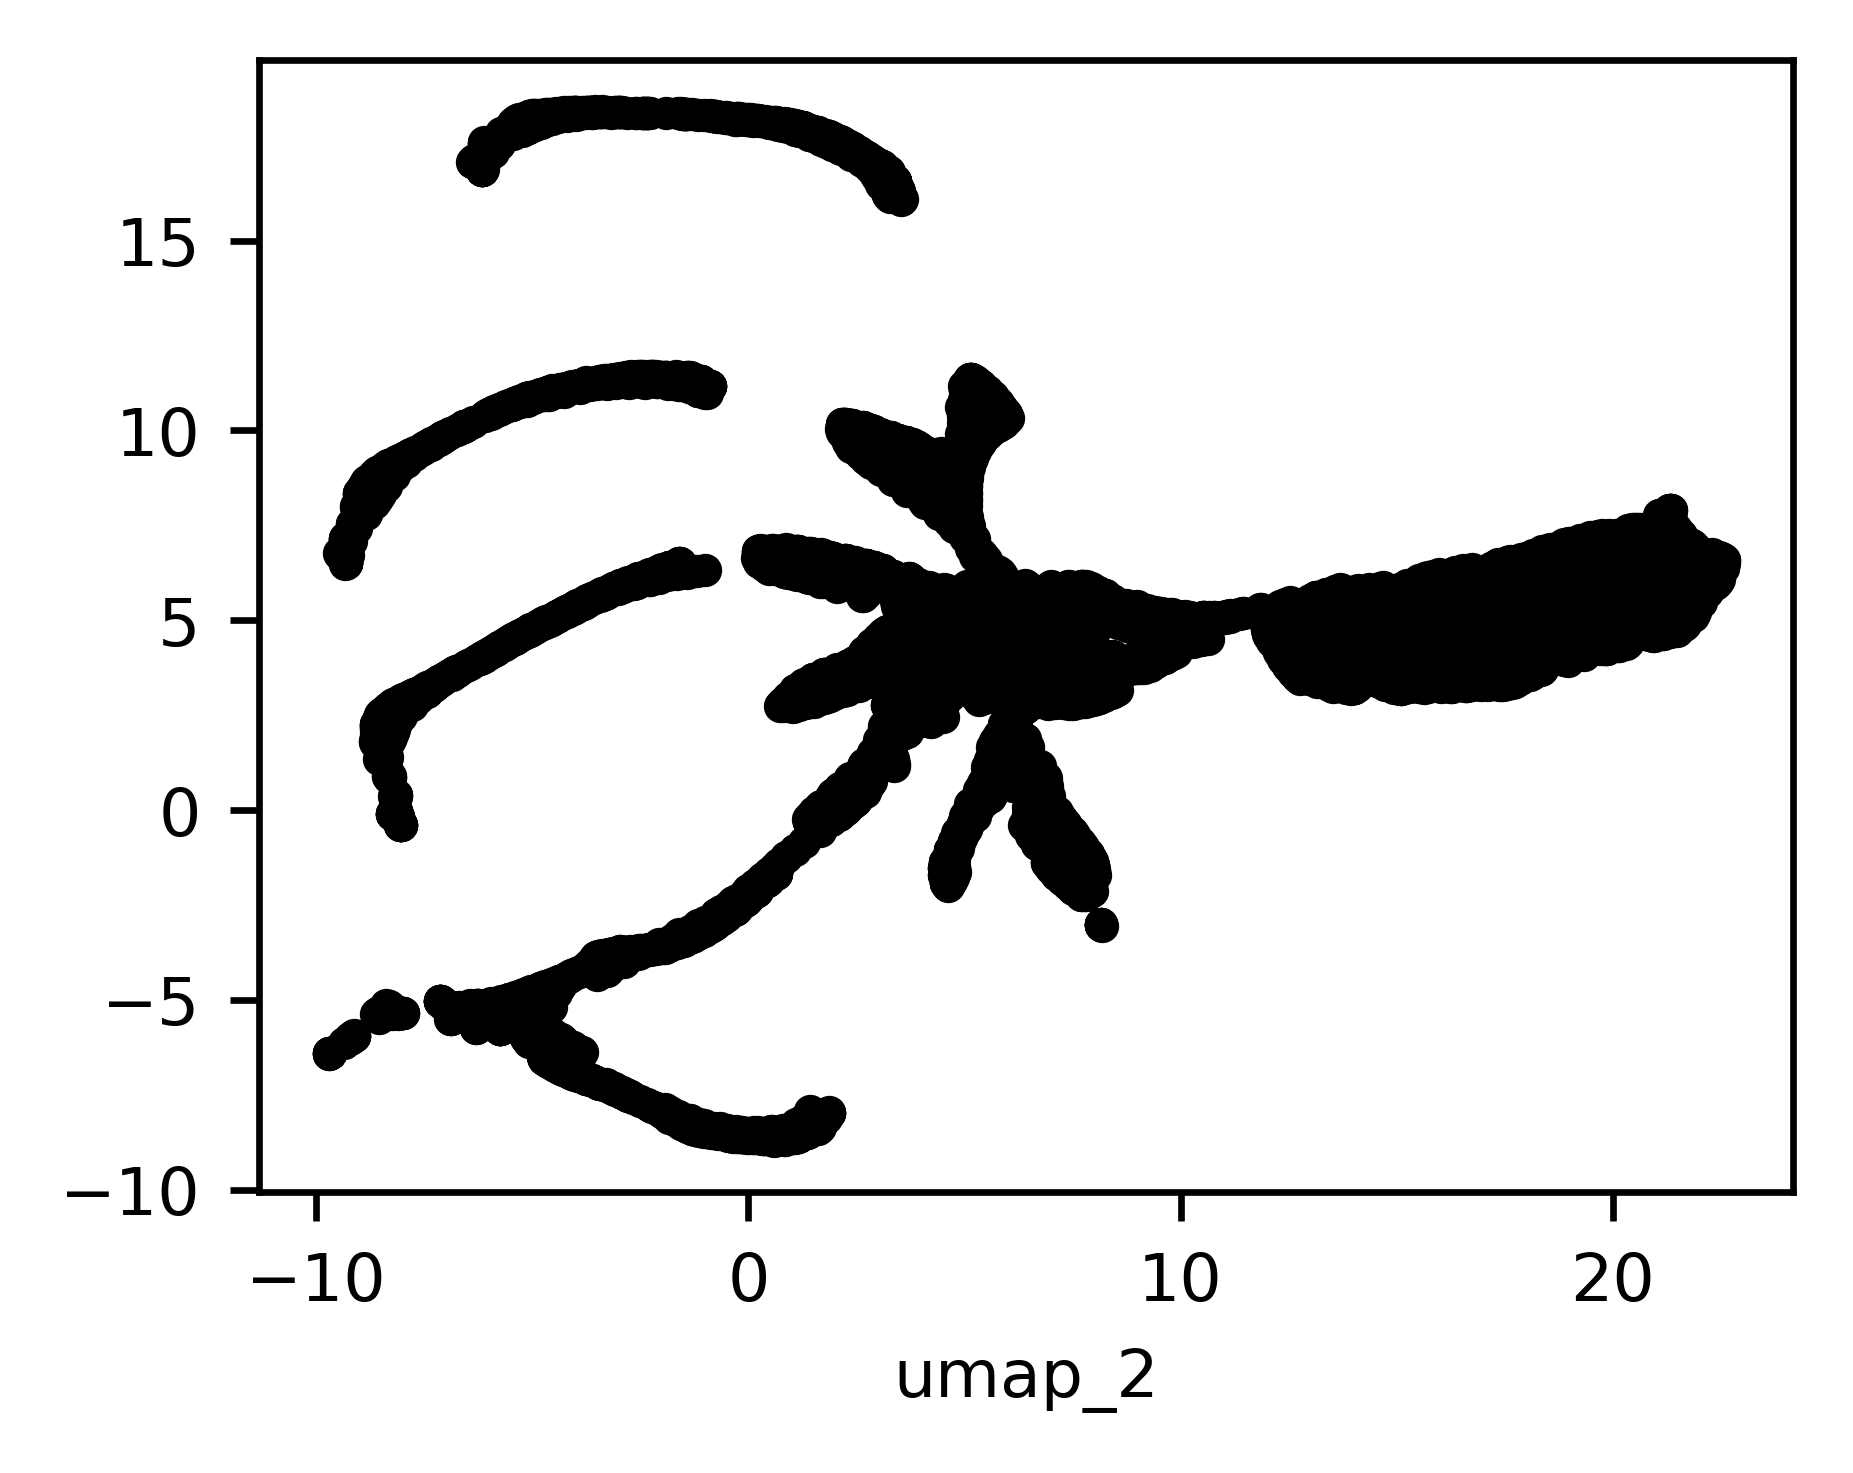

In [91]:
plt.plot(*dfumap.T, 'k.', color = )
plt.xlabel("umap_1")
plt.xlabel("umap_2")
# plt.title("UMAP on Encoded 5D ")

In [40]:
para1d  = para[(para["OM"] == 1 ) & (para["CM"] == 3)  & (para["Lg"] == 8) & (para["Fe"]==10)]

In [41]:
idx1d = para1d.index

In [42]:
en1d = en32[idx1d,:]

In [44]:
mm.latent_dim

5

In [45]:
dfen = pd.DataFrame(data = en1d,columns=[f"pc{i}"  for i in range(1, mm.latent_dim + 1) ])

In [53]:
dfen["Teff"] =  T_eff

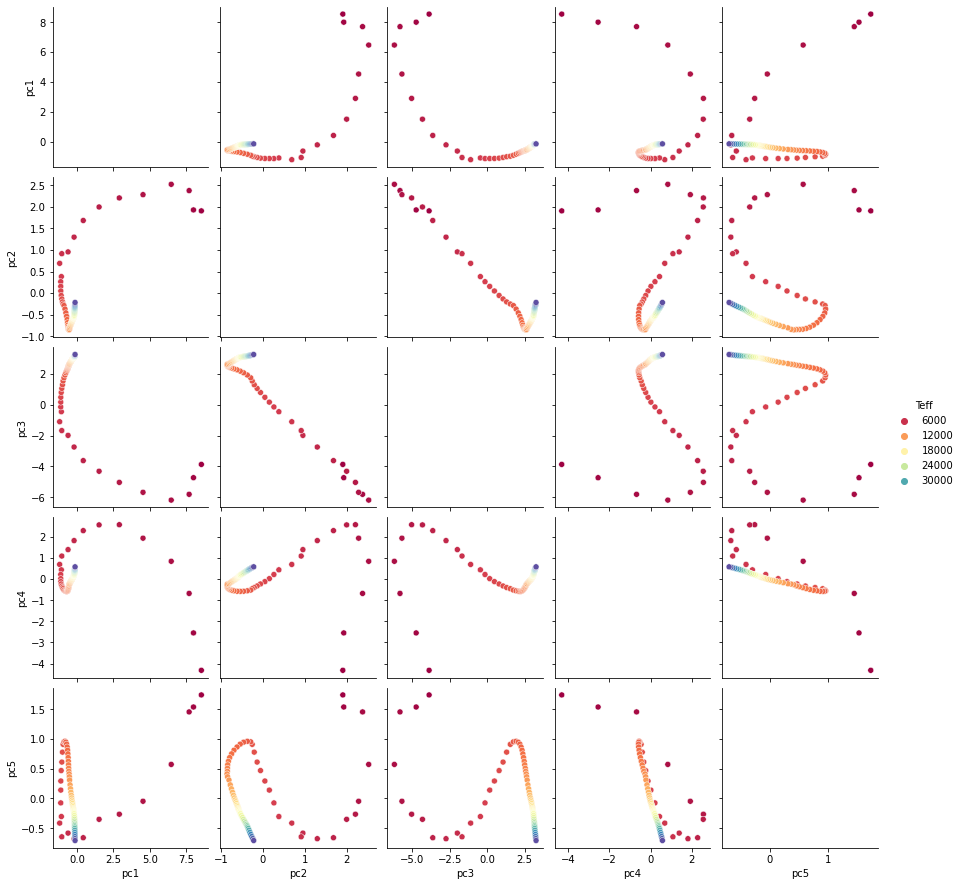

In [59]:
sns.pairplot(dfen, hue="Teff", palette="Spectral")